# Credit Risk Analysis 

The data contains the credit details about credit borrowers. Data Description:

1. age - Age of Customer
2. ed - Education level of customer
3. employ: Tenure with current employer (in years)
4. address: Number of years in same address
5. income: Customer Income
6. debtinc: Debt to income ratio
7. creddebt: Credit to Debt ratio
8. othdebt: Other debts
10. default: Customer defaulted in the past (1= defaulted, 0=Never defaulted)

## 0. Dependencies

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt  # For 2D visualization
from plotly.tools import make_subplots
import plotly.graph_objs as go
from scipy import stats          # For statistics
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score

# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

"""Evaluation metrics."""
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


In [218]:
"""Customize visualization."""
plt.style.use("bmh")                    # Use bmh's style for plotting
sns.set_style({"axes.grid":False})      # Remove gridlines

"""Display markdown formatted output like bold, italic bold etc."""
from IPython.display import Markdown
def bold(string):
    return display(Markdown(f"**{string}**"))

## 1. Loading the Data

In [219]:
df = pd.read_csv('bankloans.csv')
df.head(5)

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608      1.0
1   27   1      10        6      31     17.3   1.362202  4.000798      0.0
2   40   1      15       14      55      5.5   0.856075  2.168925      0.0
3   41   1      15       14     120      2.9   2.658720  0.821280      0.0
4   24   2       2        0      28     17.3   1.787436  3.056564      1.0

In [220]:
df.tail(5)

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
845   34   1      12       15      32      2.7  0.239328  0.624672      NaN
846   32   2      12       11     116      5.7  4.026708  2.585292      NaN
847   48   1      13       11      38     10.8  0.722304  3.381696      NaN
848   35   2       1       11      24      7.8  0.417456  1.454544      NaN
849   37   1      20       13      41     12.9  0.899130  4.389870      NaN

In [221]:
df.shape

(850, 9)

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [223]:
#Summary statistics
df.describe()

age          ed      employ     address      income     debtinc  \
count  850.000000  850.000000  850.000000  850.000000  850.000000  850.000000   
mean    35.029412    1.710588    8.565882    8.371765   46.675294   10.171647   
std      8.041432    0.927784    6.777884    6.895016   38.543054    6.719441   
min     20.000000    1.000000    0.000000    0.000000   13.000000    0.100000   
25%     29.000000    1.000000    3.000000    3.000000   24.000000    5.100000   
50%     34.000000    1.000000    7.000000    7.000000   35.000000    8.700000   
75%     41.000000    2.000000   13.000000   12.000000   55.750000   13.800000   
max     56.000000    5.000000   33.000000   34.000000  446.000000   41.300000   

         creddebt     othdebt     default  
count  850.000000  850.000000  700.000000  
mean     1.576805    3.078789    0.261429  
std      2.125840    3.398803    0.439727  
min      0.011696    0.045584    0.000000  
25%      0.382176    1.045942    0.000000  
50%      0.885091    2.003243    0.000000  
75%      1.898440    3.903001    1.000000  
max     20.561310   35.197500    1.000000

## 2. Exploratory Analysis

In [224]:
df.isnull().sum()

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

In [225]:
df['default'].isnull().sum()/df.shape[0]*100 

17.647058823529413

Findings: Nearly 18% of the data under defaults are missing. So we are going to impute missing values with the median, considering default as a quantitative variable.

In [226]:
display(df["default"].median)

<bound method NDFrame._add_numeric_operations.<locals>.median of 0      1.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
845    NaN
846    NaN
847    NaN
848    NaN
849    NaN
Name: default, Length: 850, dtype: float64>

In [227]:
#Imputing with the mode since variable is categorical
df.default.fillna(value=df.default.median(), inplace = True)
#imp_default = SimpleImputer(strategy = 'median')
#df[['default']] = imp_default.fit_transform(bankloan[['default']])

In [228]:
df['default'].isnull().sum()/df.shape[0]*100 

0.0

#### 2.1 Univariate Analysis

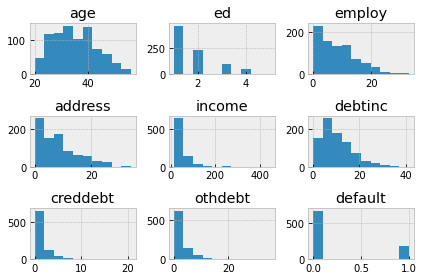

In [229]:
df.hist()
plt.tight_layout()

In [230]:
"""#1.Create a function to plot histogram and density plot."""
def plotHistogram(variable):
    """Plots histogram and density plot of a variable."""
    
    # Create subplot object.
    fig = make_subplots(
        rows=2,
        cols=1,
        print_grid=False,
    subplot_titles=(f"Distribution of {variable.name} with Histogram", f"Distribution of {variable.name} with Density Plot"))
    
    # This is a count histogram
    fig.add_trace(
        go.Histogram(
            x = variable,
            hoverinfo="x+y",
            marker = dict(color = "chocolate")
        ),
    row=1,col=1)
    
    # This is a density histogram
    fig.add_trace(
        go.Histogram(
            x = variable,
            hoverinfo="x+y",
            histnorm = "density",
            marker = dict(color = "darkred")
        ),
    row=2,col=1)
    
    # Update layout
    fig.layout.update(
        height=800, 
        width=870,
        hovermode="closest",
        showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    # Update axes
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Density(%)</b>")
    fig.layout.xaxis2.update(title=f"<b>{variable.name}</b>")
    return fig.show()
    

    
'''#2.Calculate descriptive statistics.'''
def calculateSummaryStats(variable):
    stats = variable.describe()
    skewness = pd.Series(variable.skew(), index = ["skewness"])
    statsDf = pd.DataFrame(pd.concat([skewness, stats], sort = False), columns = [variable.name])
    statsDf = statsDf.reset_index().rename(columns={"index":"summaryStats"})
    return display(statsDf.round(2))

In [231]:
plotHistogram(df.age)
plotHistogram(df.ed)
plotHistogram(df.employ)
plotHistogram(df.address)
plotHistogram(df.income)
plotHistogram(df.debtinc)
plotHistogram(df.creddebt)
plotHistogram(df.othdebt)

In [232]:
"""Create a function to plot a variable's absolute and relative frequency."""
def plotFrequency(variable):
    """Plots absolute and relative frequency of a avriable."""
    
    # Calculates absolute frequency
    absFreq = variable.value_counts()
    
    # Calculates relative frequency
    relFreq = variable.value_counts(normalize=True).round(4)*100
    
    # Creates a dataframe off absolute and relative frequency
    df = pd.DataFrame({
        "absoluteFrequency":absFreq,
        "relativeFrequency":relFreq
    })
    
    # Create two subplots of bar chart
    fig=make_subplots(
        rows=1, 
        cols=2,
        vertical_spacing=0.3,
        subplot_titles=("Absolute Frequency", "Relative Frequency"),
        print_grid=False) # This suppresses "This is the format of your plot grid:" text from popping out.

    # Add trace for absolute frequency
    fig.add_trace(
        go.Bar(
        y=df.index, 
        x=df.absoluteFrequency,
        orientation="h",
        text=df.absoluteFrequency,
        hoverinfo="x+y",
        textposition="auto", 
        name="Abs Freq",
        textfont=dict(family="sans serif",size=14),
        marker = dict(color=df.absoluteFrequency, colorscale="Rainbow")),
        row=1,
        col=1
        )

    # Add another trace for relative frequency
    fig.add_trace(
        go.Bar(y=df.index,
        x=df.relativeFrequency.round(2),
        orientation="h",
        text=df.relativeFrequency.round(2),
        hoverinfo="x+y",
        textposition="auto", 
        name="Rel Freq(%)",
        textfont=dict(family="sans serif",size=15),
        marker=dict(color=df.relativeFrequency.round(2), colorscale="Rainbow")),
        row=1,
        col=2
        )

    # Update the layout. Add title, dimension, and background color
    fig.layout.update(
        height=600, 
        width=970,
        hovermode="closest",
        title_text=f"Absolute and Relative Frequency of {variable.name}",showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )

    # Set y-axis title in bold
    fig.layout.yaxis1.update(title=f"<b>{variable.name}</b>")
    
    # Set x-axes titles in bold
    fig.layout.xaxis1.update(title="<b>Abs Freq</b>")
    fig.layout.xaxis2.update(title="<b>Rel Freq(%)</b>")
    # or, fig["layout"]["xaxis2"].update(title="<b>Rel Freq(%)</b>")
    return fig.show()
"""Univariate analysis of the variables"""
plotFrequency(df.default)

## 2. Detecting Outliers

We will use boxplots for visualizing a continuous variable. It will helps us identify outliers.

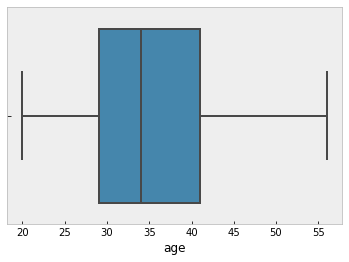

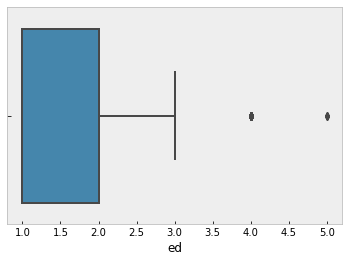

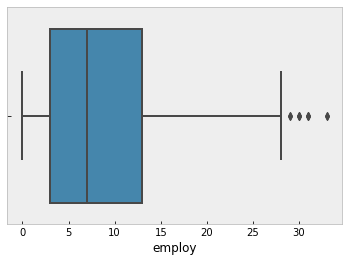

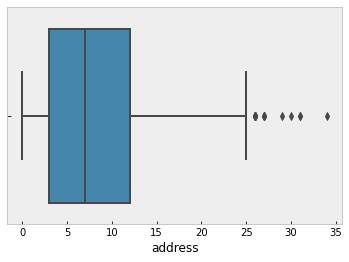

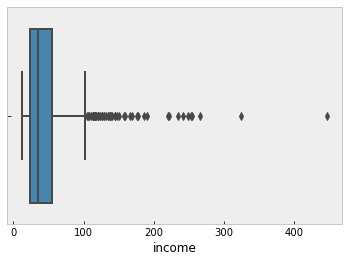

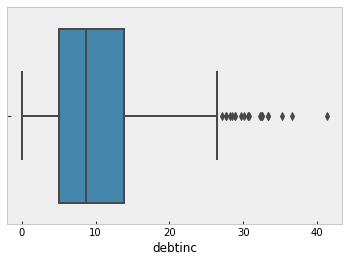

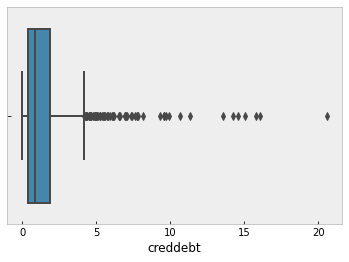

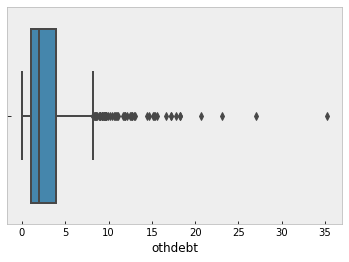

In [233]:
sns.boxplot(data=df, x='age')
plt.show()
sns.boxplot(data=df, x='ed')
plt.show()
sns.boxplot(data=df, x='employ')
plt.show()
sns.boxplot(data=df, x='address')
plt.show()
sns.boxplot(data=df, x='income')
plt.show()
sns.boxplot(data=df, x='debtinc')
plt.show()
sns.boxplot(data=df, x='creddebt')
plt.show()
sns.boxplot(data=df, x='othdebt')
plt.show()

In [234]:
"""#1.Create a function that removes outliers"""
def removeOutliers(variable):
    """Calculates and removes outliers using IQR method."""
    
    # Calculate 1st, 3rd quartiles and iqr.
    q1, q3 = variable.quantile(0.25), variable.quantile(0.75)
    iqr = q3 - q1
    
    # Calculate lower fence and upper fence for outliers
    lowerFence, upperFence = q1-1.5*iqr, q3+1.5*iqr   # Any values less than l_fence and greater than u_fence are outliers.
    
    # Observations that are outliers
    outliers = variable[(variable<lowerFence) | (variable>upperFence)]
    
    # Drop obsevations that are outliers
    filtered = variable.drop(outliers.index, axis = 0).reset_index(drop=True)
    return filtered


"""#2.Create another function to plot boxplot with and without outliers."""
def plotBoxPlot(variable,filteredVariable):
    """Plots Box plot of a variable with and without outliers.
    We will also use the output of removeOutliers function as the input to this function.
    variable = variable with outliers,
    filteredVariable = variable without outliers"""
    
    # Create subplot object.
    fig = make_subplots(
        rows=2,
        cols=1,
        print_grid=False,
    subplot_titles=(f"{variable.name} Distribution with Outliers", f"{variable.name} Distribution without Outliers"))
    
    # This trace plots boxplot with outliers
    fig.add_trace(
        go.Box(
            x = variable,
            name = "", # This removes trace 0
            marker = dict(color="darkred")
        ),
    row=1,col=1)
    
    # This trace plots boxplot without outliers
    fig.add_trace(
        go.Box(
            x = filteredVariable,
            name = "",
            marker = dict(color="green")
        ),
    row=2,col=1)
    
    # Update layout
    fig.layout.update(
        height=800, 
        width=870,
        showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    # Update axes
    fig.layout.xaxis2.update(title=f"<b>{variable.name}</b>")
    return fig.show()

In [235]:
"""Plot ed with and without outliers."""
plotBoxPlot(df.ed,removeOutliers(df.ed))

In [236]:
"""Plot address with and without outliers."""
plotBoxPlot(df.address,removeOutliers(df.address))

In [237]:
"""Plot employ with and without outliers."""
plotBoxPlot(df.employ,removeOutliers(df.employ))

In [238]:
"""Plot income with and without outliers."""
plotBoxPlot(df.income,removeOutliers(df.income))

In [239]:
"""Plot debtinc with and without outliers."""
plotBoxPlot(df.debtinc,removeOutliers(df.debtinc))

In [240]:
"""Plot creddebt with and without outliers."""
plotBoxPlot(df.creddebt,removeOutliers(df.creddebt))

In [241]:
"""Plot othdebt with and without outliers."""
plotBoxPlot(df.othdebt,removeOutliers(df.othdebt))

#### 2.2 Bivariate Analysis

In [242]:
"""#1.Create a function that creates boxplot between categorical and numerical variables and calculates biserial correlation."""
def boxplotAndCorrelation(numVariable,catVariable=df.default):
    """Return boxplot between a categorical and numerical variable. Also calculates biserial correlation.
    numVariable = a numerical variable of interest."""
    
    # Calculate point biserial correlation and p value
    biserialCorr = stats.pointbiserialr(numVariable,catVariable)[0].round(2)
    pValue = stats.pointbiserialr(numVariable,catVariable)[1].round(5)
    
    # Create subplot object.
    fig = make_subplots(
        rows=1,
        cols=1,
        print_grid=False,
    )
    
    # This trace plots boxplot of categorical variable vs numerical variable
    fig.add_trace(
        go.Box(
            x = catVariable,
            y = numVariable,
            marker_color="lightseagreen",
            ))
    
    
    # Update layout
    fig.layout.update(
        height=500, 
        width=900,
        showlegend=False,
        title_text= f"Association between {catVariable.name} and {numVariable.name} (corr: {biserialCorr}, p: {pValue})",
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    # Update axes
    fig.layout.xaxis1.update(title=f"<b>{catVariable.name}</b>")
    fig.layout.yaxis1.update(title=f"<b>{numVariable.name}</b>")
    return fig.show()
"""#3.This function plots histogram of numerical variable for every class of categorical variable."""
def numHistByCat(numVariable,catVariable=df.default):
    """Returns numerical variable distribution across classes of categorical variable."""
    fig,ax = plt.subplots(1,1,figsize = (18,7))
    font_size = 15
    title_size = 18
    numVariable[catVariable==1].hist(bins=50,color="green", label = "Defaulted", grid = False, alpha=0.5)
    numVariable[catVariable==0].hist(bins=50,color="red", label = "Not defaulted", grid = False, alpha=0.5)
    ax.set_yticks([])
    ax.tick_params(axis="x", labelsize=font_size)
    ax.set_xlabel(f"{numVariable.name}", fontsize = font_size)
    ax.set_title(f"{numVariable.name} Distribution of defaulters and Non-Defaulters", fontsize = title_size)
    plt.legend()
    return plt.show()

   
"""#4.Create a function to calculate anova between numerical and categorical variable."""
def calculateAnova(numVariable, catVariable=df.default):
    """Returns f statistics and p value after anova calculation."""
    
    groupNumVariableByCatVariable1 = numVariable[catVariable==1] # Group our numerical variable by categorical variable(1). Group Fair by survivors
    groupNumVariableByCatVariable0 = numVariable[catVariable==0] # Group our numerical variable by categorical variable(0). Group Fare by victims
    # Calculate one way anova
    fValue, pValue = stats.f_oneway(groupNumVariableByCatVariable1, groupNumVariableByCatVariable0) # Calculate f statistics and p value
    return f"Anova Result between {numVariable.name} & {catVariable.name}: f=> {fValue}, p=> {pValue}"

In [243]:
"""Create a boxplot to visualize the strength of association of default with age. Also calculate biserial correlation."""
boxplotAndCorrelation(df.age)

Findings: The plot shows that there is little negative to no correlation between the two variables. This is confirmed by the small negative correlation coefficient, indicating that younger individuals are more likely to default the loan. The p-value is nealy 0.00012, which shows that this correlation is statistically significant.

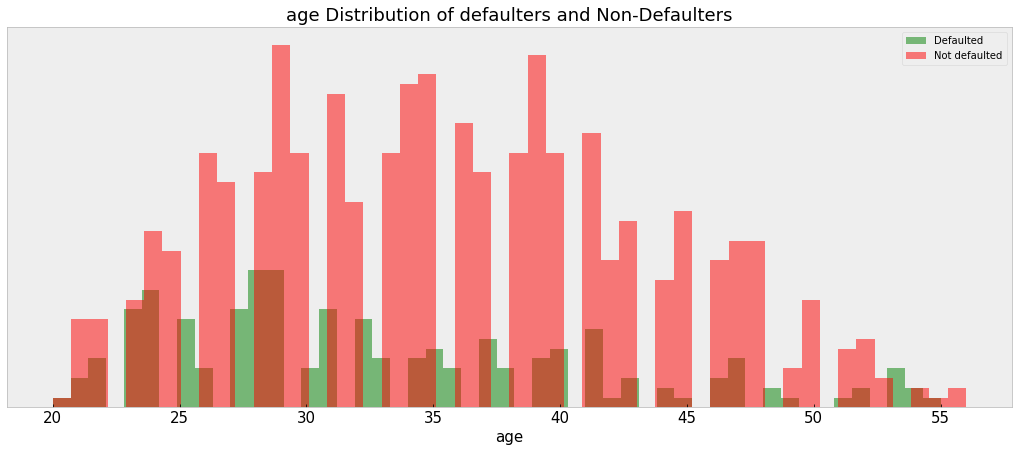

In [244]:
#Plot histogram of default's vs age.
numHistByCat(df.age)

Finding: Another confirmation that defaulters are mainly younger adults.

In [245]:
"""Create a boxplot to visualize the strength of association of default with education. Also calculate biserial correlation."""
boxplotAndCorrelation(df.ed)

Findings: The plot shows that there is little positive to no correlation between the two variables. This is confirmed by the small positive correlation coefficient, indicating that more educated individuals are more likely to default the loan. The p-value is nealy 0.00163, which shows that this correlation is statistically significant

In [246]:
"""Create a boxplot to visualize the strength of association of default with employ. Also calculate biserial correlation."""
boxplotAndCorrelation(df.employ)

Findings: The plot shows that there is a weak negative correlation between the two variables. This is confirmed by the small negative correlation coefficient, indicating that individuals with less years of employment are more likely to default the loan. The p-value is approximately 0.0, which shows that this correlation is statistically significant.

In [247]:
"""Create a boxplot to visualize the strength of association of default with address. Also calculate biserial correlation."""
boxplotAndCorrelation(df.address)

Findings: The plot shows that there is little negative correlation between the two variables. This is confirmed by the small negative correlation coefficient, indicating that individuals who who recently relocated or moved  are more likely to default the loan. The p-value is approximately 0.00001, which shows that this correlation is statistically significant.

In [248]:
"""Create a boxplot to visualize the strength of association of default with income. Also calculate biserial correlation."""
boxplotAndCorrelation(df.income)

Findings: The plot shows that there is little negative to no correlation between the two variables. This is confirmed by the small negative correlation coefficient, indicating that individuals with lower incomes are more likely to default the loan. The p-value is approximately 0.03037, which shows that this correlation is statistically significant.

In [249]:
"""Create a boxplot to visualize the strength of association of default with debtinc. Also calculate biserial correlation."""
boxplotAndCorrelation(df.debtinc)

Findings: The plot shows that there is a positive correlation between the two variables. This is confirmed by the  negative correlation coefficient, indicating that individuals with higher debt to income ratio are more likely to default the loan. The p-value is approximately 0.0, which shows that this correlation is statistically significant.

In [250]:
"""Create a boxplot to visualize the strength of association of default with creddebt. Also calculate biserial correlation."""
boxplotAndCorrelation(df.creddebt)

Findings: The plot shows that there is positive correlation between the two variables. This is confirmed by the positive correlation coefficient, indicating that individuals with Credit to Debt ratio are more likely to default the loan. The p-value is approximately 0.0, which shows that this correlation is statistically significant.

In [251]:
"""Create a boxplot to visualize the strength of association of default with othdebt. Also calculate biserial correlation."""
boxplotAndCorrelation(df.othdebt)

Findings: The plot shows that there is little positive correlation between the two variables. This is confirmed by the small positive correlation coefficient, indicating that individuals with more other debts are more likely to default the loan. The p-value is approximately 0.00041, which shows that this correlation is statistically significant.

## 3. Multivariate Analysis

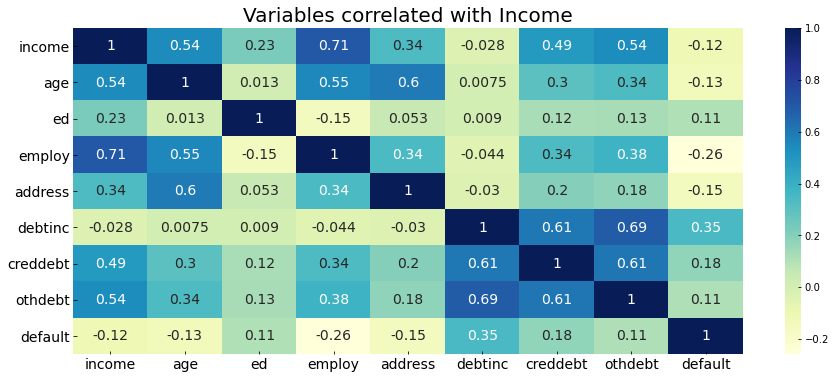

In [252]:
"""Let's plot correlation heatmap to see which variable is highly correlated with Income and if our 
boxplot interpretation holds true. We need to convert categorical variable into numerical to plot 
correlation heatmap. So convert categorical variables into numerical."""
from sklearn.preprocessing import LabelEncoder
df = df.agg(LabelEncoder().fit_transform)
df["income"] = df.income # Inserting Age in dataframe "toSearch".
df = df.set_index("income").reset_index() # Move Age column at index 0.

# Now create the correlation heatmap
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.heatmap(df.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Variables correlated with Income", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
ax.tick_params(axis = "both", which = "minor", labelsize = 14)
plt.show()

Findings: It can be seen that income is highly correlated with years at employment and moderately correlated with age and  debts. We will examine how combining income with the other variables impact client ability to avoid defaulting the loan.

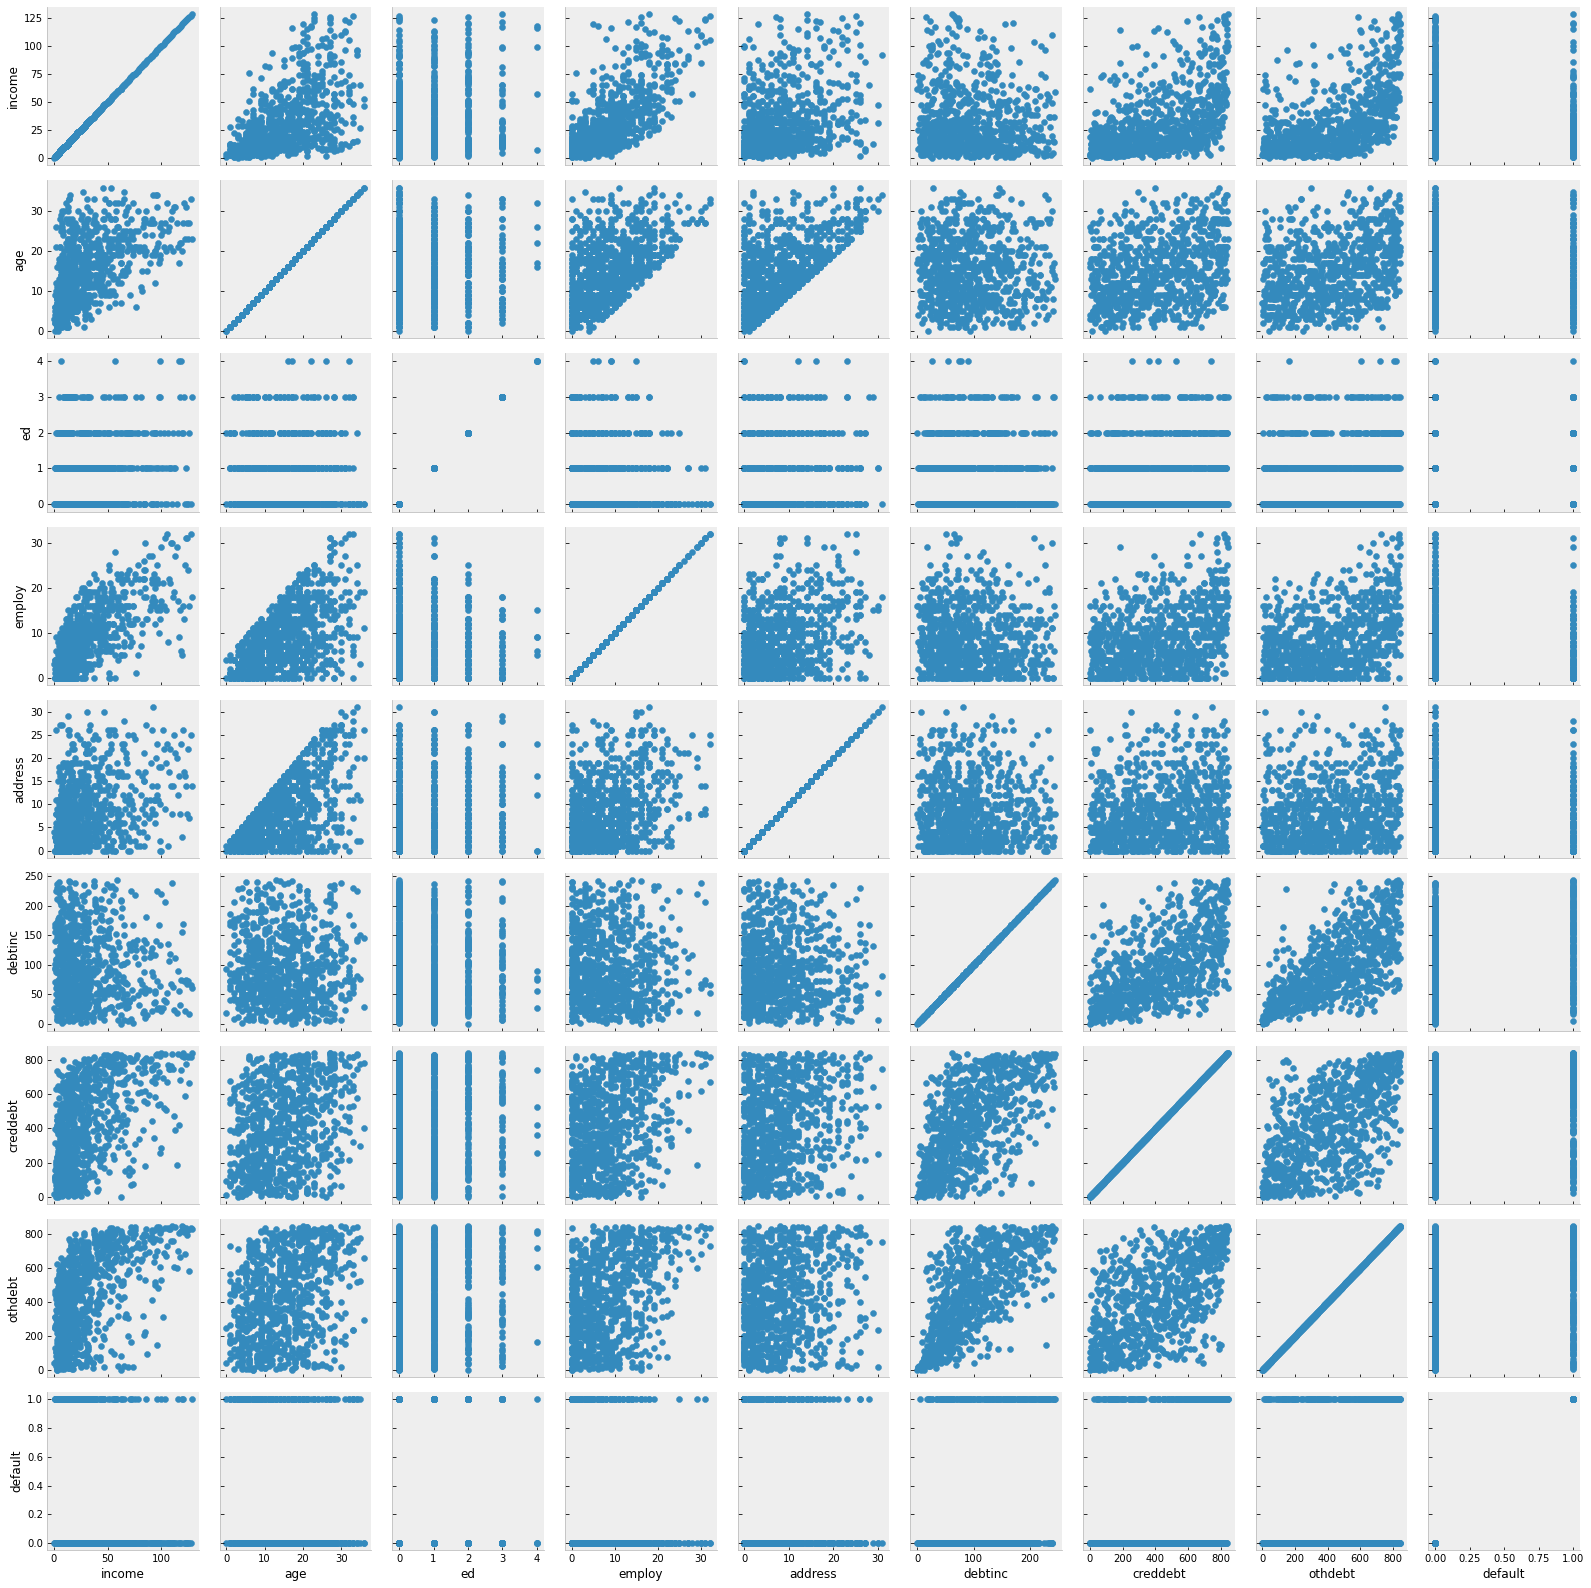

In [253]:
g = sns.PairGrid(df)
g.map(plt.scatter)

## 4. Feature Engeniering and Lodel Training without Resampling

In [254]:
df['default'].value_counts()

0    667
1    183
Name: default, dtype: int64

In [255]:
#Check Imballanced of the default variable
df['default'].value_counts()/len(df['default'].index)*100

0    78.470588
1    21.529412
Name: default, dtype: float64

The data is clearly imbalanced in this category.

First we will perform the modelling without resampling the data.

#### 4.1 Splitting th data

In [256]:
X = df.drop(['default','employ'], axis =1)
y = df['default']


In [257]:
X.shape

(850, 7)

In [258]:
xTrain,  xTest, yTrain, yTest = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 44)

In [259]:
"""See the dimensions of input and output data set."""
print(f"Input Matrix Dimension: {xTrain.shape}")
print(f"Output Vector Dimension: {yTrain.shape}")
print(f"Test Data Dimension: {xTest.shape}")
print(f"Test Data Dimension: {yTest.shape}")

Input Matrix Dimension: (680, 7)
Output Vector Dimension: (680,)
Test Data Dimension: (170, 7)
Test Data Dimension: (170,)


#### 4.2 Model Training

 We would train 10 different classifiers for this binary classification problem.

In [260]:
"""Machine learning models"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
"""Set a seed for reproducibility"""
seed = 44
"""Building machine learning models: 
We will try 10 different classifiers to find the best classifier after tunning model's hyperparameters that will best generalize the unseen(test) data."""

"""Now initialize all the classifiers object."""
"""#1.Logistic Regression"""
lr = LogisticRegression()

"""#2.Support Vector Machines"""
svc = SVC(kernel = "linear")

"""#3.Random Forest Classifier"""
rf = RandomForestClassifier(random_state = seed, n_estimators = 100)

"""#4.KNN"""
knn = KNeighborsClassifier()

"""#5.Gaussian Naive Bayes"""
gnb = GaussianNB()

"""#6.Decision Tree Classifier"""
dt = DecisionTreeClassifier(random_state = seed)

"""#7.Gradient Boosting Classifier"""
gbc = GradientBoostingClassifier(random_state = seed)

"""#8.Adaboost Classifier"""
abc = AdaBoostClassifier(random_state = seed)

"""#9.ExtraTrees Classifier"""
etc = ExtraTreesClassifier(random_state = seed)

"""#10.Extreme Gradient Boosting"""
xgbc = XGBClassifier(random_state = seed)


"""List of all the models with their indices."""
modelNames = ["LR", "SVC", "RF", "KNN", "GNB", "DT", "GBC", "ABC", "ETC", "XGBC"]
models = [lr, svc, rf, knn, gnb, dt, gbc, abc, etc, xgbc]

In [330]:
"""Create a function that returns train accuracy of different models."""
def calculateTrainAccuracy(model):
    """Returns training accuracy of a model."""
    
    model.fit(xTraino, yTraino)
    trainAccuracy = model.score(xTrain, yTrain)
    trainAccuracy = round(trainAccuracy*100, 2)
    return trainAccuracy

# Calculate train accuracy of all the models and store them in a dataframe
modelScores = list(map(calculateTrainAccuracy, models))
trainAccuracy = pd.DataFrame(modelScores, columns = ["trainAccuracy"], index=modelNames)
trainAccuracySorted = trainAccuracy.sort_values(by="trainAccuracy", ascending=False)
bold("Training Accuracy of the Classifiers:")
display(trainAccuracySorted)

**Training Accuracy of the Classifiers:**

trainAccuracy
RF           100.00
DT           100.00
ETC          100.00
XGBC         100.00
GBC           87.21
KNN           78.82
ABC           77.94
SVC           72.35
LR            72.21
GNB           63.24

Findings: Looks like all the models perform very well with SVC, RF, DT, ETC and XGBC having 100% accuracy. But train accuracy of a model is not enough  as it is done on trained data. Can these models also perform well on test dat, or data not seen? We need to evaluate these models.

#### 4.3 Model Evaluation

##### K-Fold Cross Validation
Let's use 10-fold cross validation. So k = 10 and we have total 680 observations. Each fold would have 680/10 = 68 observations. So basically k-fold cross validation uses fold-1 (68 samples) as the testing set and k-1 (9 folds) as the training sets and calculates test accuracy.This procedure is repeated k times (if k = 10, then 10 times); each time, a different group of observations is treated as a validation or test set. This process results in k estimates of the test accuracy which are then averaged out.

In [262]:
"""Create a function that returns mean cross validation score for different models."""
def calculateXValScore(model):
    """Returns models' cross validation scores."""
    
    xValScore = cross_val_score(model, xTrain, yTrain, cv = 10, scoring="accuracy").mean()
    xValScore = round(xValScore*100, 2)
    return xValScore

# Calculate cross validation scores of all the models and store them in a dataframe
modelScores = list(map(calculateXValScore, models))
xValScores = pd.DataFrame(modelScores, columns = ["xValScore"], index=modelNames)
xValScoresSorted = xValScores.sort_values(by="xValScore", ascending=False)
bold("Models 10-fold Cross Validation Score:")
display(xValScoresSorted)

**Models 10-fold Cross Validation Score:**

xValScore
ETC       80.15
RF        80.00
XGBC      80.00
GBC       79.85
ABC       79.26
GNB       78.68
LR        78.53
SVC       78.53
KNN       77.50
DT        72.50

Findings: In this case, ETC, RF, XGBC have the highest scores, DT as the lowest score.

#### 4.4 Feature Importance

 Let's visualize the features importance as prioritized by our classifiers.

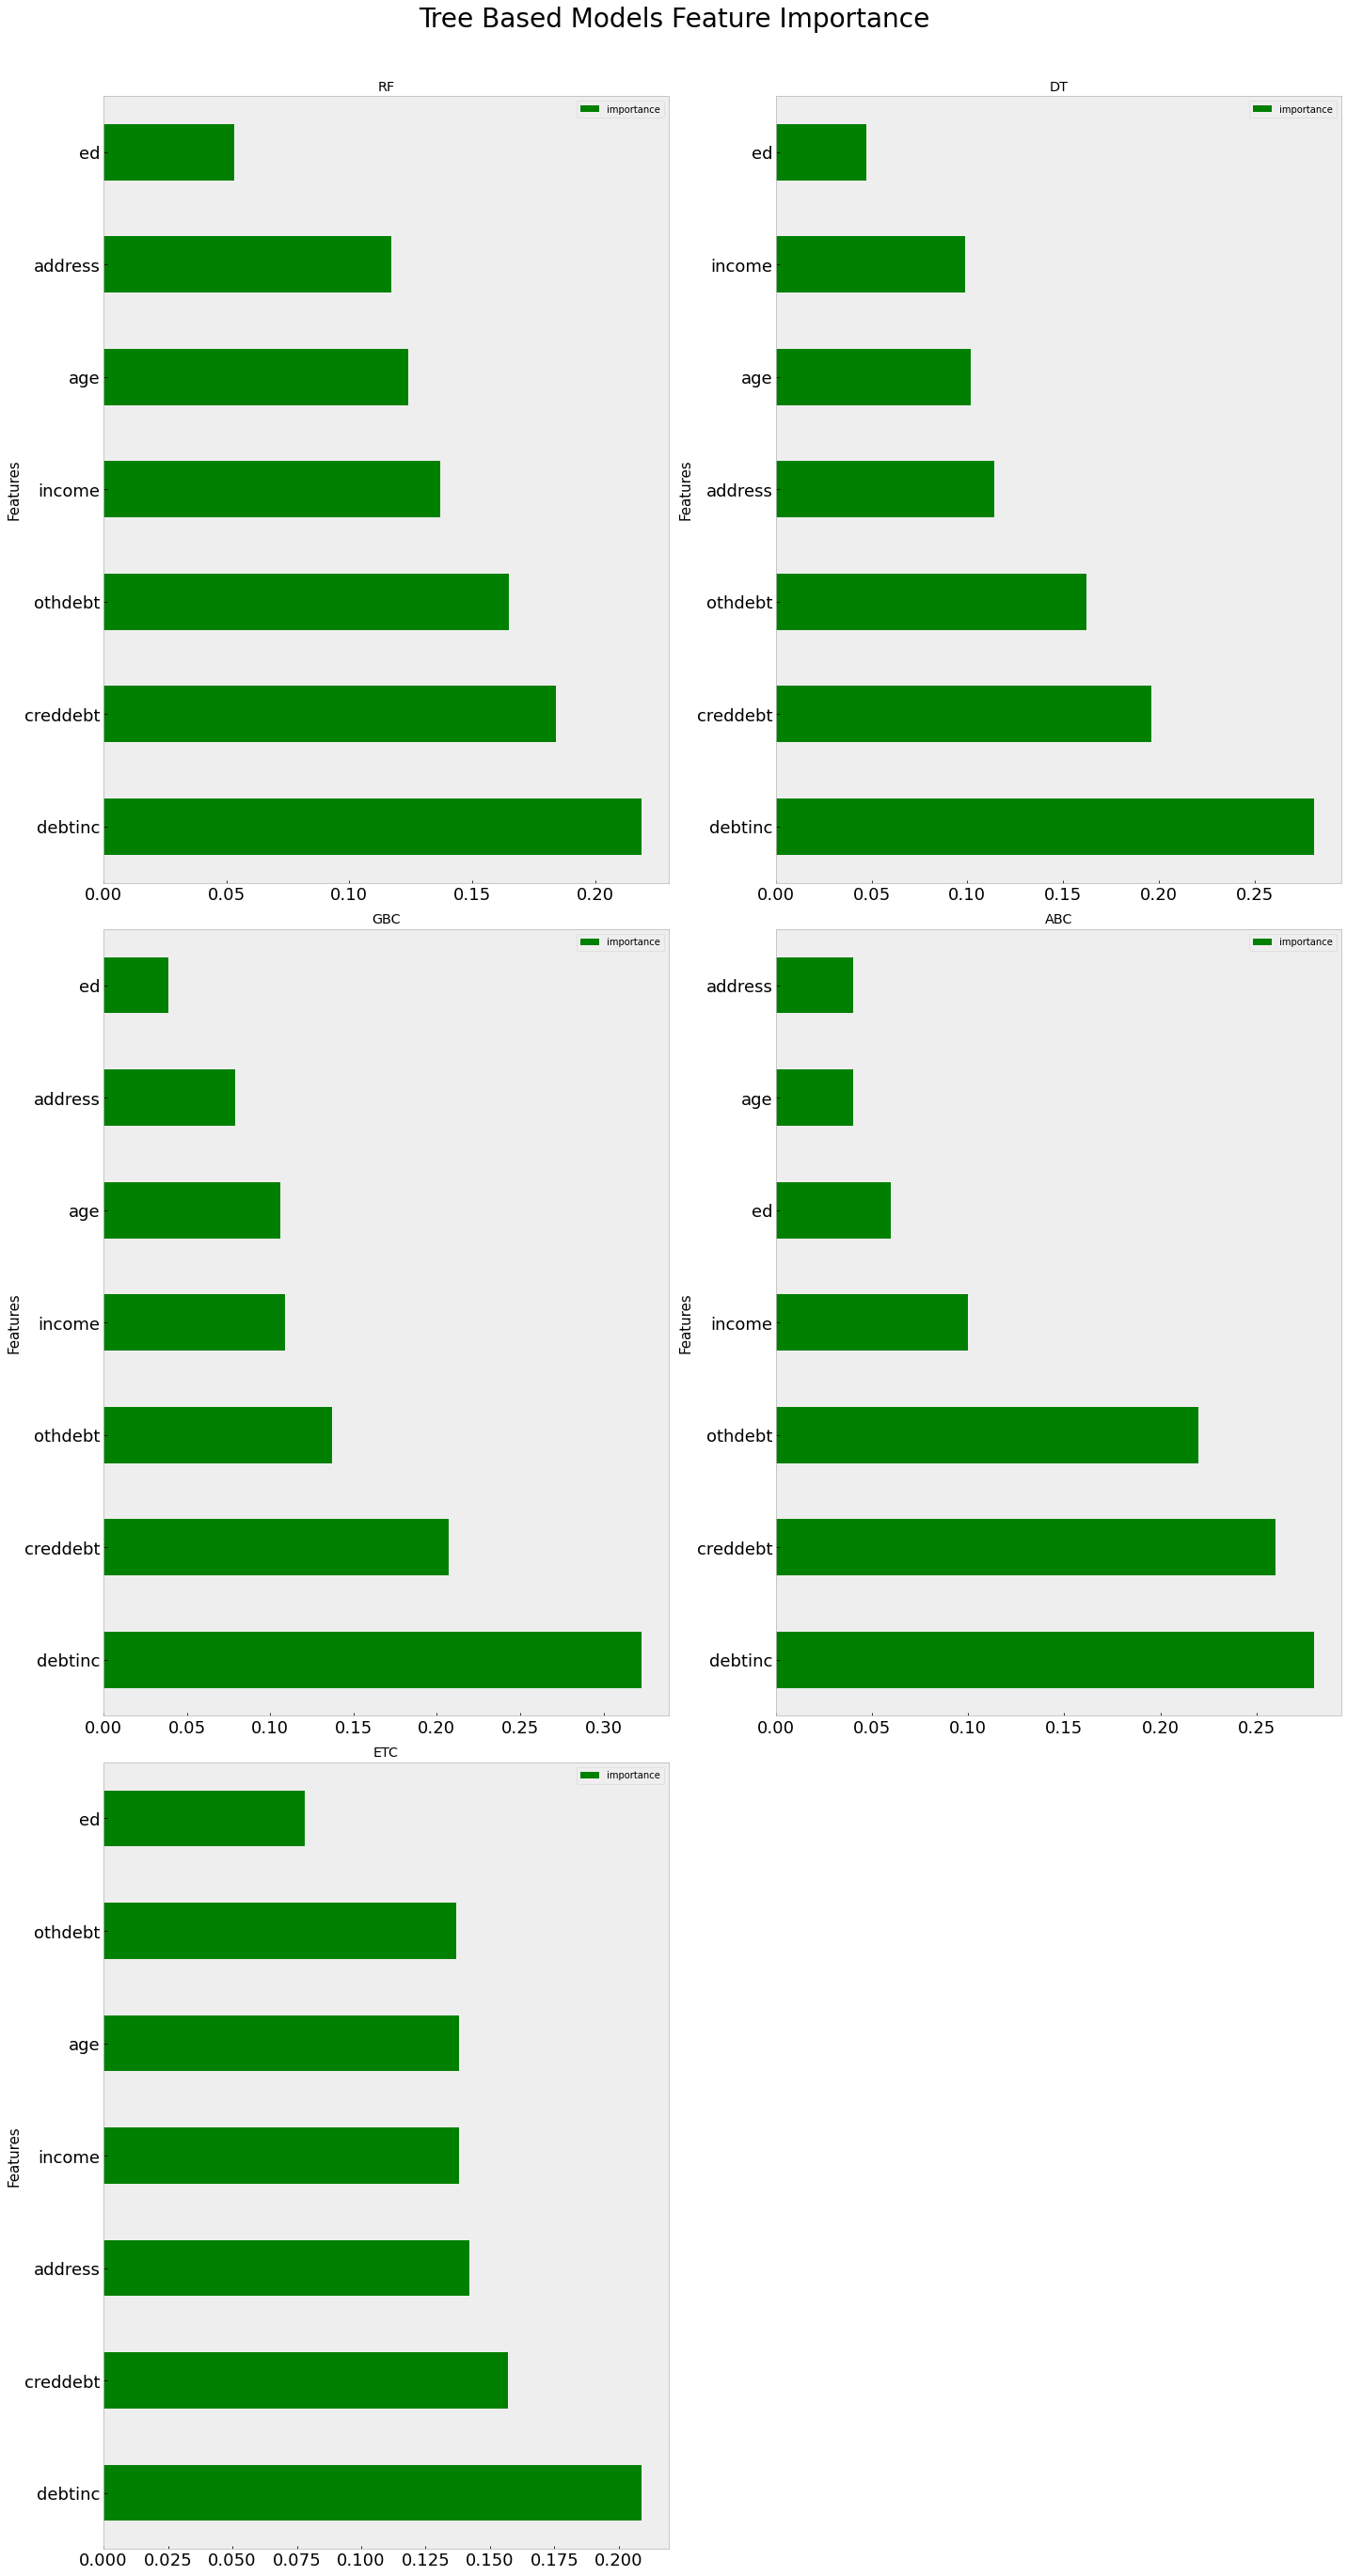

In [263]:

"""Create a function that plot feature importance by the selected tree based models."""
def plotFeatureImportance(model):
    """Return a plot of feature importance by model."""
    
    importance = pd.DataFrame({"feature": xTrain.columns,
                              "importance": np.round(model.feature_importances_,3)})
    importanceSorted = importance.sort_values(by = "importance", ascending = False).set_index("feature")
    return importanceSorted

"""Create subplots of feature impotance of "RF", "KNN", "GNB", "DT", "GBC", "ABC", "ETC", "XGBC"."""
fig, axes = plt.subplots(3,2, figsize = (20,40))
fig.suptitle("Tree Based Models Feature Importance", fontsize = 28)
sModels = [rf,dt, gbc, abc, etc, xgbc]
sModelNames = ["RF","DT", "GBC", "ABC", "ETC", "XGBC"]
for ax, model, name in zip(axes.flatten(), sModels, sModelNames):
    plotFeatureImportance(model).plot.barh(ax=ax, title=name, fontsize=18, color="green")
    ax.set_ylabel("Features", fontsize = 15)
fig.delaxes(ax = axes[2,1]) # We don"t need the last subplot.
fig.tight_layout(rect = [0, 0.03, 1, 0.97])

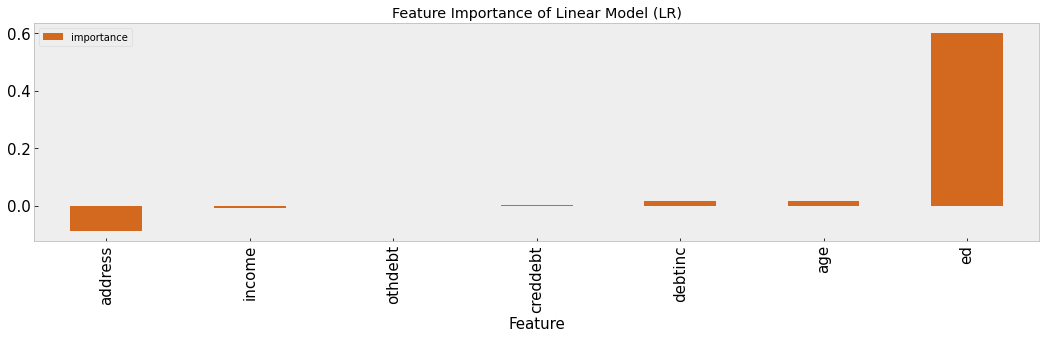

In [264]:
"""Let's plot feature importance of LR."""
fig, ax = plt.subplots(figsize=(18,4))
coeff = pd.DataFrame({"feature":xTrain.columns,
                      "importance":np.transpose(lr.coef_[0])})

coeff.sort_values(by = "importance").set_index("feature")\
.plot.bar(title = "Feature Importance of Linear Model (LR)", color="chocolate", ax=ax)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
ax.tick_params(axis = "both", which = "minor", labelsize = 15)
ax.set_xlabel("Feature", fontsize = 15)
plt.show()

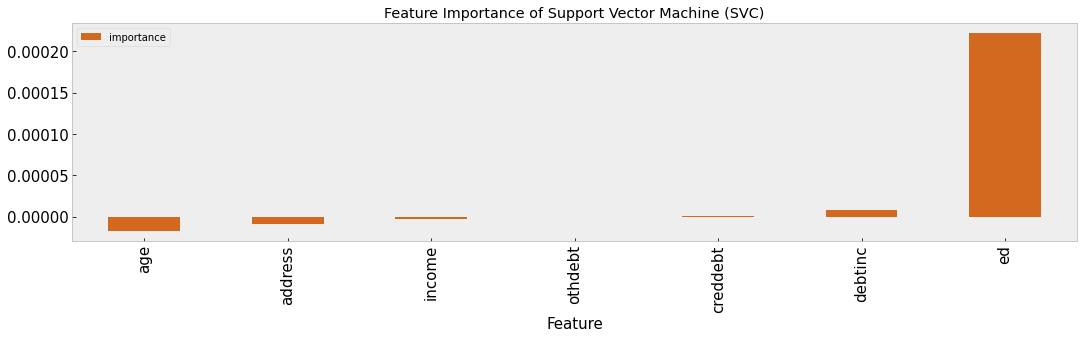

In [265]:
"""Let's plot feature importance of SVC."""
fig, ax = plt.subplots(figsize=(18,4))
coeff = pd.DataFrame({"feature":xTrain.columns,
                      "importance":np.transpose(svc.coef_[0])})

coeff.sort_values(by = "importance").set_index("feature")\
.plot.bar(title = "Feature Importance of Support Vector Machine (SVC)", color="chocolate", ax=ax)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
ax.tick_params(axis = "both", which = "minor", labelsize = 15)
ax.set_xlabel("Feature", fontsize = 15)
plt.show()

In [266]:
"""Create a function that returns learning curves for different classifiers."""
def plotLearningCurve(model):
    """Returns a plot of learning curve of a model."""
    
    # Create feature matrix and target vector
    X, y = xTrain, yTrain
    # Create CV training and test scores for various training set sizes
    trainSizes, trainScores, testScores = learning_curve(model, X, y, cv = 10,
                                                    scoring="accuracy", n_jobs = -1, 
                                                    train_sizes = np.linspace(0.01, 1.0, 17), # 17 different sizes of the training set
                                                    random_state = seed)
                                                    

    # Create means and standard deviations of training set scores
    trainMean = np.mean(trainScores, axis = 1)
    trainStd = np.std(trainScores, axis = 1)

    # Create means and standard deviations of test set scores
    testMean = np.mean(testScores, axis = 1)
    testStd = np.std(testScores, axis = 1)

    # Draw lines
    plt.plot(trainSizes, trainMean, "o-", color = "red",  label = "training score")
    plt.plot(trainSizes, testMean, "o-", color = "green", label = "cross-validation score")
    
    # Draw bands
    plt.fill_between(trainSizes, trainMean - trainStd, trainMean + trainStd, alpha = 0.1, color = "r") # Alpha controls band transparency.
    plt.fill_between(trainSizes, testMean - testStd, testMean + testStd, alpha = 0.1, color = "g")

    # Create plot
    font_size = 15
    plt.xlabel("Training Set Size", fontsize = font_size)
    plt.ylabel("Accuracy Score", fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = "best")
    plt.grid()

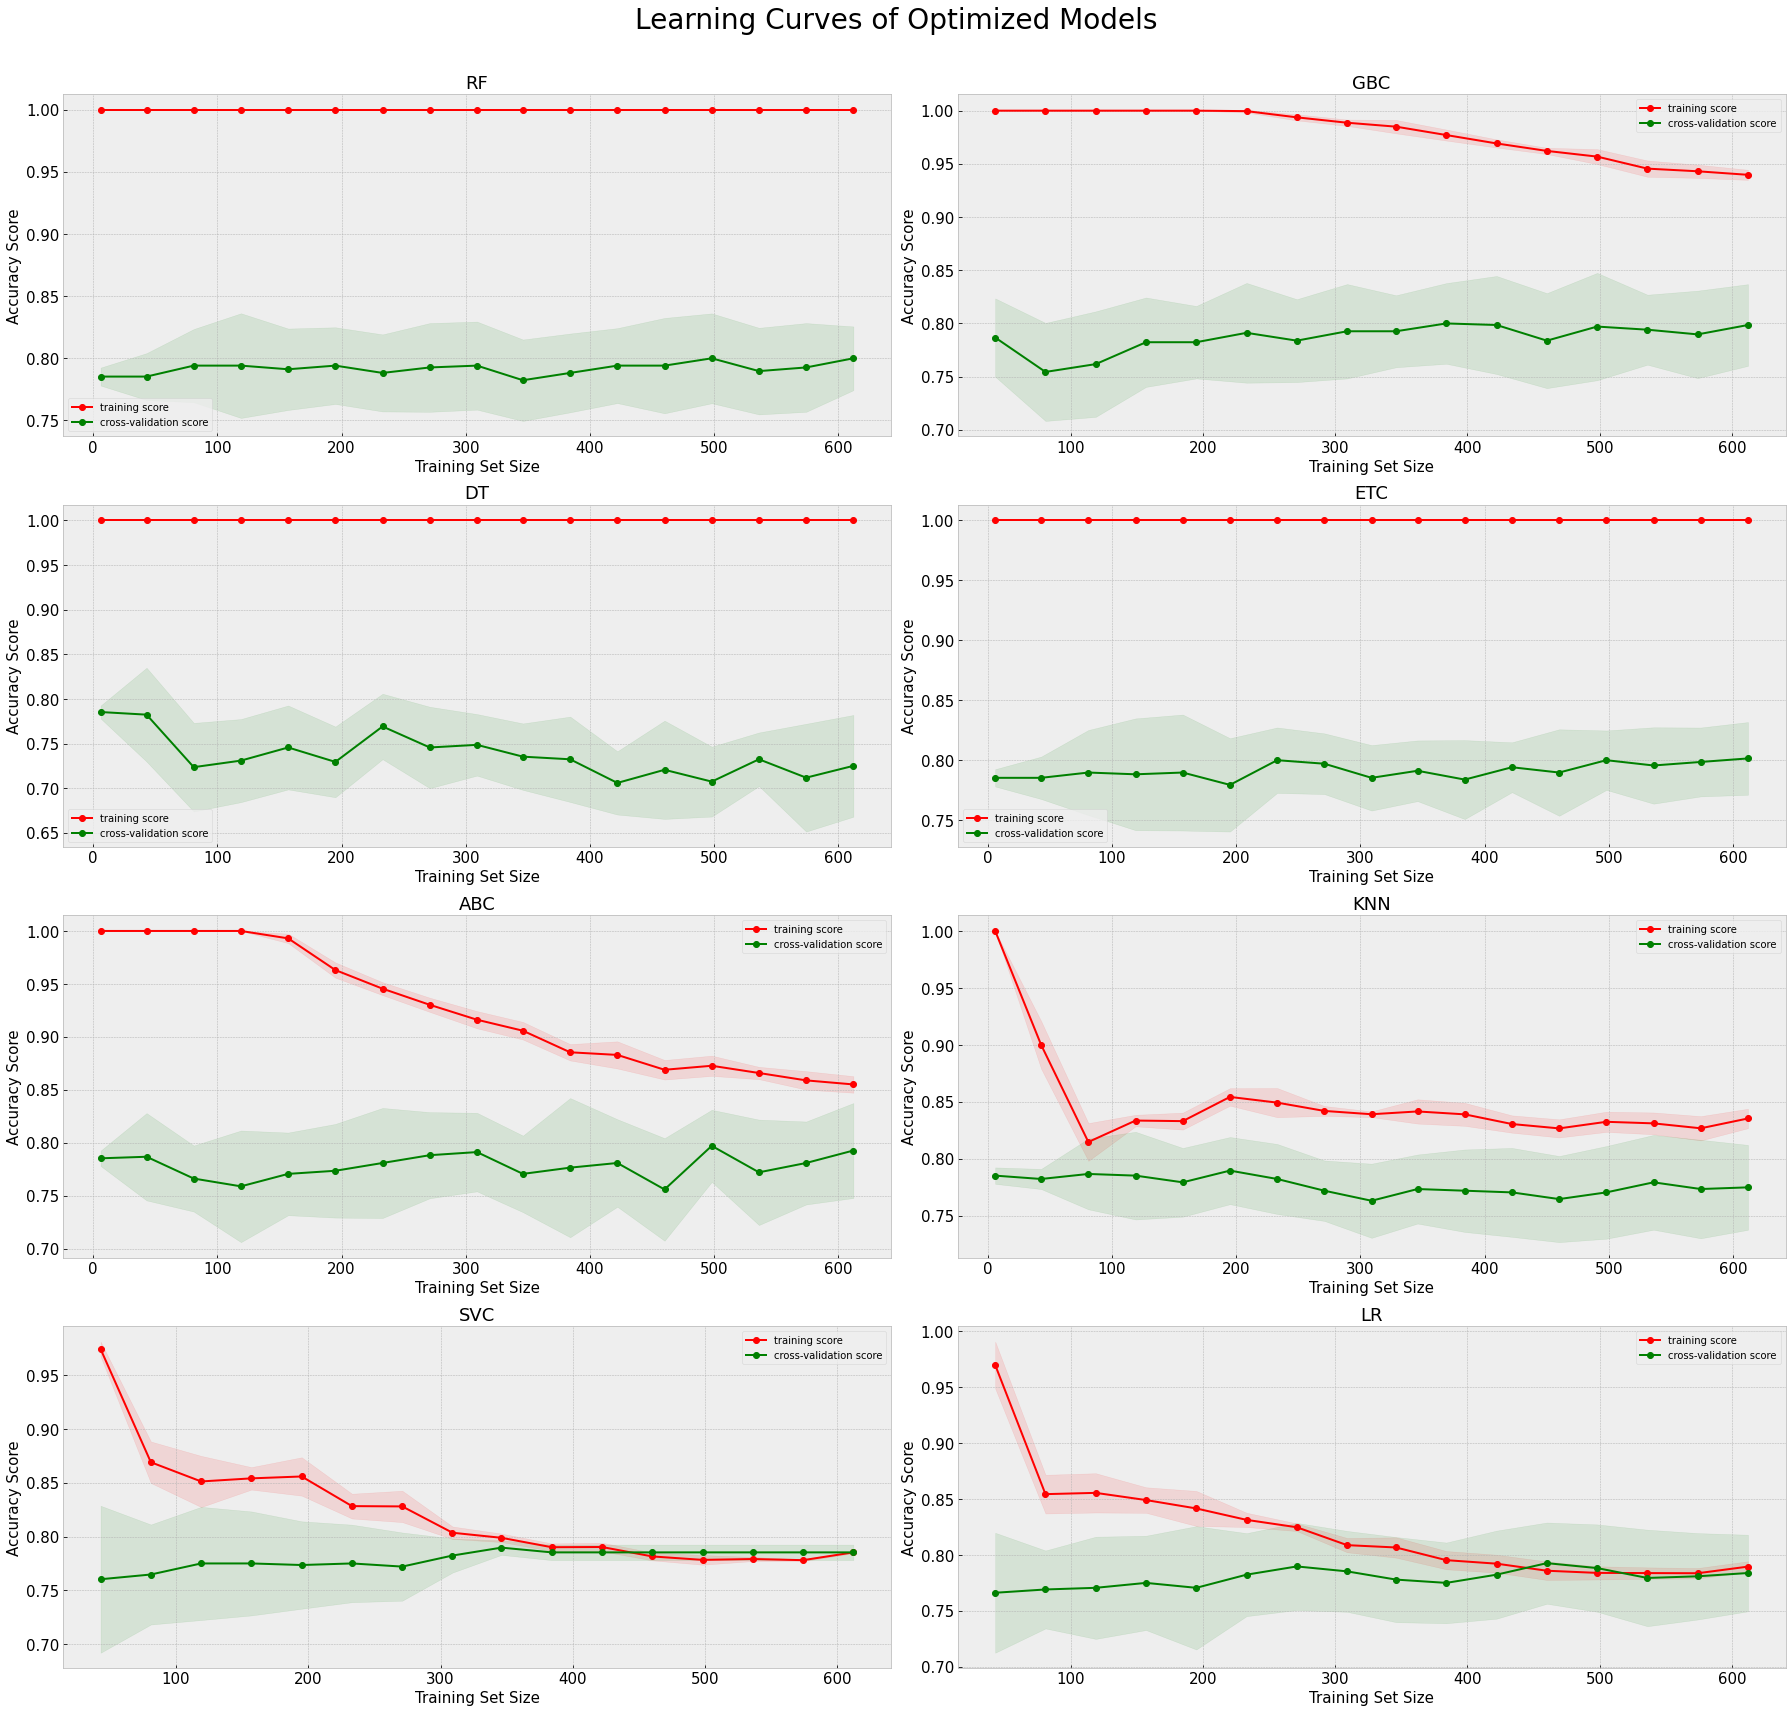

In [267]:
"""Now plot learning curves of the optimized models in subplots."""
plt.figure(figsize = (25,25))
lcModels = [rf, gbc, dt, etc, abc, knn, svc, lr]
lcLabels = ["RF", "GBC", "DT", "ETC", "ABC", "KNN", "SVC", "LR"]

for ax, model, label in zip (range(1,9), lcModels, lcLabels):
    plt.subplot(4,2,ax)
    plotLearningCurve(model)
    plt.title(label, fontsize = 18)
plt.suptitle("Learning Curves of Optimized Models", fontsize = 28)
plt.tight_layout(rect = [0, 0.03, 1, 0.97])

Findings:

.....

#### 4.5 Confusion Matrix

In [268]:
"""Return prediction to use it in another function."""
def xValPredict(model):
    """Returns prediction by which we can calculate different classification metrics."""
    
    predicted = cross_val_predict(model, xTrain, yTrain, cv = 10)
    return predicted # Now we can use it in another function by assigning the function to its return value.

"""Function to return confusion matrix."""
def calculateConfusionMatrix(model):
    """returns a models confusion matrix"""
    
    predicted = xValPredict(model)
    confusionMatrix = pd.crosstab(yTest, predicted, rownames = ["Actual"],
                                   colnames = ["Predicted/Classified"], margins = True)
    return display(confusionMatrix)

"""Now calculate confusion matrix of the models."""
bold("ETC Confusion Matrix:")
calculateConfusionMatrix(etc)
bold("RF Confusion Matrix:")
calculateConfusionMatrix(rf)
bold("GBC Confusion Matrix:")
calculateConfusionMatrix(gbc)
bold("XGBC Confusion Matrix:")
calculateConfusionMatrix(xgbc)
bold("ABC Confusion Matrix:")
calculateConfusionMatrix(abc)
bold("GNB Confusion Matrix:")
calculateConfusionMatrix(gnb)
bold("SVC Confusion Matrix:")
calculateConfusionMatrix(svc)
bold("KNN Confusion Matrix:")
calculateConfusionMatrix(knn)
bold("DT Confusion Matrix:")
calculateConfusionMatrix(dt)

**ETC Confusion Matrix:**

Predicted/Classified    0   1  All
Actual                            
0                     509  25  534
1                     110  36  146
All                   619  61  680

**RF Confusion Matrix:**

Predicted/Classified    0   1  All
Actual                            
0                     505  29  534
1                     107  39  146
All                   612  68  680

**GBC Confusion Matrix:**

Predicted/Classified    0   1  All
Actual                            
0                     497  37  534
1                     100  46  146
All                   597  83  680

**XGBC Confusion Matrix:**

Predicted/Classified    0   1  All
Actual                            
0                     490  44  534
1                      92  54  146
All                   582  98  680

**ABC Confusion Matrix:**

Predicted/Classified    0   1  All
Actual                            
0                     494  40  534
1                     101  45  146
All                   595  85  680

**GNB Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                     480   54  534
1                      91   55  146
All                   571  109  680

**SVC Confusion Matrix:**

Predicted/Classified    0  All
Actual                        
0                     534  534
1                     146  146
All                   680  680

**KNN Confusion Matrix:**

Predicted/Classified    0   1  All
Actual                            
0                     497  37  534
1                     116  30  146
All                   613  67  680

**DT Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                     440   94  534
1                      93   53  146
All                   533  147  680

#### 4.6 Precision Score

In [269]:
"""Function to calculate precision score."""
def calculatePrecisionScore(model):
    """Calculates a model's precision score."""
    
    predicted = xValPredict(model)
    precisionScore = precision_score(yTrain, predicted)
    return round(precisionScore*100, 2)

"""Compute precision score for rf and gbc."""
print(f"RF  Precision Score: {calculatePrecisionScore(rf)}")
print(f"XGBC Precision Score: {calculatePrecisionScore(xgbc)}")
print(f"ABC  Precision Score: {calculatePrecisionScore(abc)}")
print(f"GBC Precision Score: {calculatePrecisionScore(gbc)}")
print(f"GNB  Precision Score: {calculatePrecisionScore(gnb)}")
print(f"SVC Precision Score: {calculatePrecisionScore(svc)}")
print(f"KNN  Precision Score: {calculatePrecisionScore(knn)}")
print(f"DT Precision Score: {calculatePrecisionScore(dt)}")
print(f"ETC Precision Score: {calculatePrecisionScore(etc)}")

RF  Precision Score: 57.35
XGBC Precision Score: 55.1
ABC  Precision Score: 52.94
GBC Precision Score: 55.42
GNB  Precision Score: 50.46
SVC Precision Score: 0.0
KNN  Precision Score: 44.78
DT Precision Score: 36.05
ETC Precision Score: 59.02


#### 4.7 Recall (or Sensitivity or True Positive Rate)

Recall is the ratio of true positive to total actual positive(true positive + false negative). So recall score basically calculates true positives from total actual positives.

In [270]:
"""Function to calculate recall score."""
def calculateRecallScore(model):
    """Calculate a model's recall score."""
    
    predicted = xValPredict(model)
    recallScore = recall_score(yTrain, predicted)
    return round(recallScore*100, 2)

"""Compute Recall score for rf and gbc."""
print(f"RF  Recall Score: {calculateRecallScore(rf)}")
print(f"XGBC Recall Score: {calculateRecallScore(xgbc)}")
print(f"ABC  Recall Score: {calculateRecallScore(abc)}")
print(f"GBC Recall Score: {calculateRecallScore(gbc)}")
print(f"GNB  Recall Score: {calculateRecallScore(gnb)}")
print(f"SVC Recall Score: {calculateRecallScore(svc)}")
print(f"KNN  Recall Score: {calculateRecallScore(knn)}")
print(f"DT Recall Score: {calculateRecallScore(dt)}")
print(f"ETC Recall Score: {calculateRecallScore(etc)}")

RF  Recall Score: 26.71
XGBC Recall Score: 36.99
ABC  Recall Score: 30.82
GBC Recall Score: 31.51
GNB  Recall Score: 37.67
SVC Recall Score: 0.0
KNN  Recall Score: 20.55
DT Recall Score: 36.3
ETC Recall Score: 24.66


#### 4.8 Specificity ( or True Negative Rate)

Specificity is the ratio of true negative to total actual negative(true negative + false positive). Specificity is exactly the opposite of recall. So specificity score basically calculates true negatives from total actual negatives.

In [271]:
"""Function for specificity score."""
def calculateSpecificityScore(model):
    """Returns a model's specificity score."""
    
    predicted = xValPredict(model)
    tn, fp, fn, tp = confusion_matrix(yTrain, predicted).ravel()
    specificityScore = tn / (tn + fp)
    return round(specificityScore*100, 2)

"""Calculate specificity score for the models."""
print(f"RF  Specificity Score: {calculateSpecificityScore(rf)}")
print(f"XGBC Specificity Score: {calculateSpecificityScore(xgbc)}")
print(f"ABC  Specificity Score: {calculateSpecificityScore(abc)}")
print(f"GBC Specificity Score: {calculateSpecificityScore(gbc)}")
print(f"GNB  Specificity Score: {calculateSpecificityScore(gnb)}")
print(f"SVC Specificity Score: {calculateSpecificityScore(svc)}")
print(f"KNN  Specificity Score: {calculateSpecificityScore(knn)}")
print(f"DT Specificity Score: {calculateSpecificityScore(dt)}")
print(f"ETC Specificity Score: {calculateSpecificityScore(etc)}")

RF  Specificity Score: 94.57
XGBC Specificity Score: 91.76
ABC  Specificity Score: 92.51
GBC Specificity Score: 93.07
GNB  Specificity Score: 89.89
SVC Specificity Score: 100.0
KNN  Specificity Score: 93.07
DT Specificity Score: 82.4
ETC Specificity Score: 95.32


#### 4.9  F1 Score

We can't choose classifiers solely depending on their precision or recall score. Rather we need to consider both to find out the best classifiers. Here comes the f1 score which is the balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the f1 score is, the better.

In [272]:
"""Function for F1 score."""
def calculateF1Score(model):
    """Returns a model's f1 score."""
    
    predicted = xValPredict(model)
    f1Score = f1_score(yTrain, predicted)
    return round(f1Score*100, 2)

"""Calculate f1 score for models."""
print(f"RF  F1 Score: {calculateF1Score(rf)}")
print(f"XGBC F1 Score: {calculateF1Score(xgbc)}")
print(f"ABC  F1 Score: {calculateF1Score(abc)}")
print(f"GBC F1 Score: {calculateF1Score(gbc)}")
print(f"GNB  F1 Score: {calculateF1Score(gnb)}")
print(f"SVC F1 Score: {calculateF1Score(svc)}")
print(f"KNN  F1 Score: {calculateF1Score(knn)}")
print(f"DT F1 Score: {calculateF1Score(dt)}")
print(f"ETC F1 Score: {calculateF1Score(etc)}")

RF  F1 Score: 36.45
XGBC F1 Score: 44.26
ABC  F1 Score: 38.96
GBC F1 Score: 40.17
GNB  F1 Score: 43.14
SVC F1 Score: 0.0
KNN  F1 Score: 28.17
DT F1 Score: 36.18
ETC F1 Score: 34.78


#### 4.10 Classification Report

In [273]:
"""Function to compute classification report."""
def calculateClassificationReport(model):
    """Returns a model"s classification report."""
    
    predicted = xValPredict(model)
    classificationReport = classification_report(yTrain, predicted)
    return print(classificationReport)

"""Now calculate classification report for the models."""
bold("RF Classification Report:")
calculateClassificationReport(rf)
bold("XGBC Classification Report:")
calculateClassificationReport(xgbc)
bold("ABC Classification Report:")
calculateClassificationReport(abc)
bold("GBC Classification Report:")
calculateClassificationReport(gbc)
bold("GNB Classification Report:")
calculateClassificationReport(gnb)
bold("SVC Classification Report:")
calculateClassificationReport(svc)
bold("KNN Classification Report:")
calculateClassificationReport(knn)
bold("DT Classification Report:")
calculateClassificationReport(dt)
bold("ETC Classification Report:")
calculateClassificationReport(etc)

**RF Classification Report:**

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       534
           1       0.57      0.27      0.36       146

    accuracy                           0.80       680
   macro avg       0.70      0.61      0.62       680
weighted avg       0.77      0.80      0.77       680



**XGBC Classification Report:**

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       534
           1       0.55      0.37      0.44       146

    accuracy                           0.80       680
   macro avg       0.70      0.64      0.66       680
weighted avg       0.78      0.80      0.78       680



**ABC Classification Report:**

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       534
           1       0.53      0.31      0.39       146

    accuracy                           0.79       680
   macro avg       0.68      0.62      0.63       680
weighted avg       0.77      0.79      0.77       680



**GBC Classification Report:**

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       534
           1       0.55      0.32      0.40       146

    accuracy                           0.80       680
   macro avg       0.69      0.62      0.64       680
weighted avg       0.77      0.80      0.78       680



**GNB Classification Report:**

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       534
           1       0.50      0.38      0.43       146

    accuracy                           0.79       680
   macro avg       0.67      0.64      0.65       680
weighted avg       0.77      0.79      0.77       680



**SVC Classification Report:**

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       534
           1       0.00      0.00      0.00       146

    accuracy                           0.79       680
   macro avg       0.39      0.50      0.44       680
weighted avg       0.62      0.79      0.69       680



**KNN Classification Report:**

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       534
           1       0.45      0.21      0.28       146

    accuracy                           0.78       680
   macro avg       0.63      0.57      0.57       680
weighted avg       0.73      0.78      0.74       680



**DT Classification Report:**

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       534
           1       0.36      0.36      0.36       146

    accuracy                           0.73       680
   macro avg       0.59      0.59      0.59       680
weighted avg       0.73      0.72      0.73       680



**ETC Classification Report:**

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       534
           1       0.59      0.25      0.35       146

    accuracy                           0.80       680
   macro avg       0.71      0.60      0.62       680
weighted avg       0.77      0.80      0.77       680



#### 4.11 Precision-Recall vs Threshold Curve

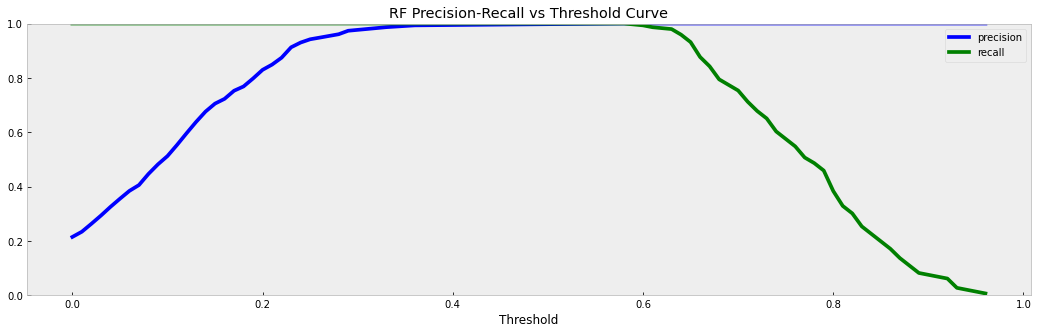

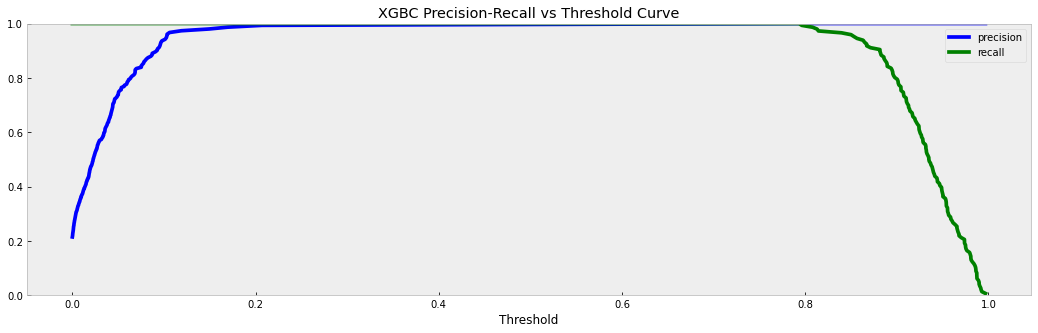

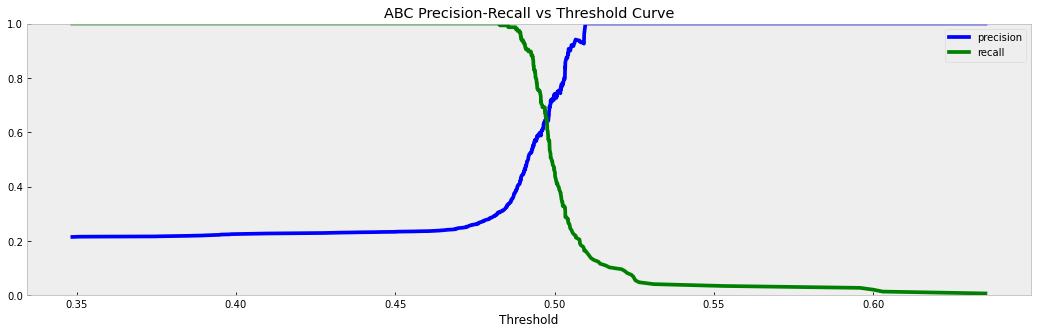

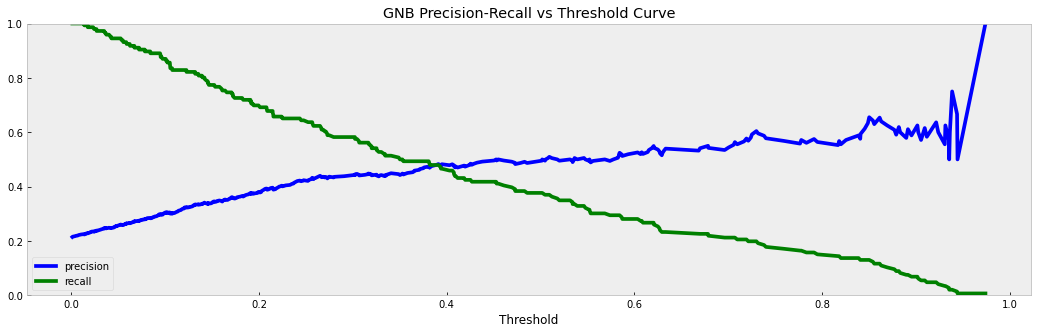

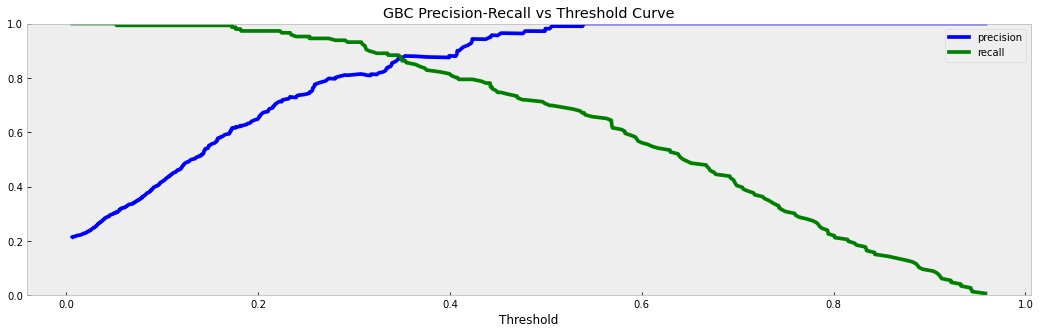

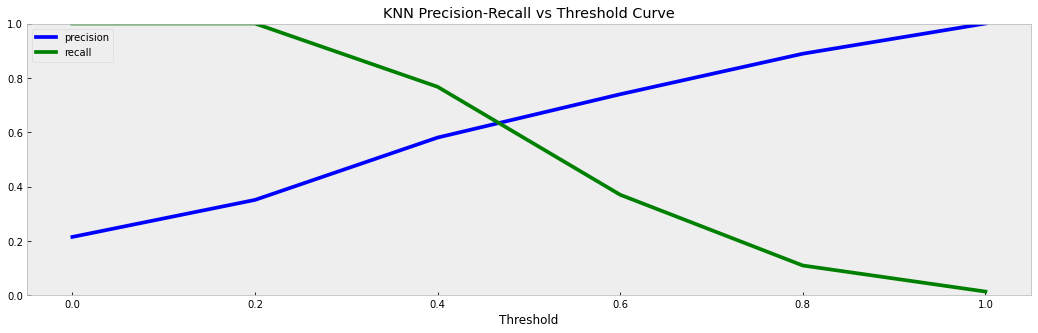

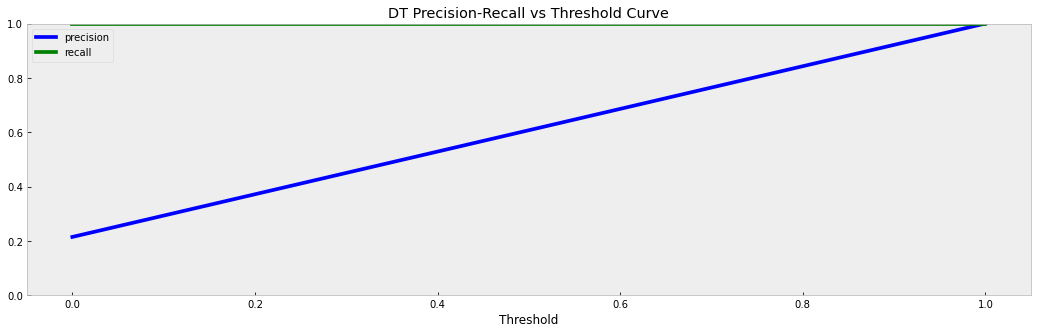

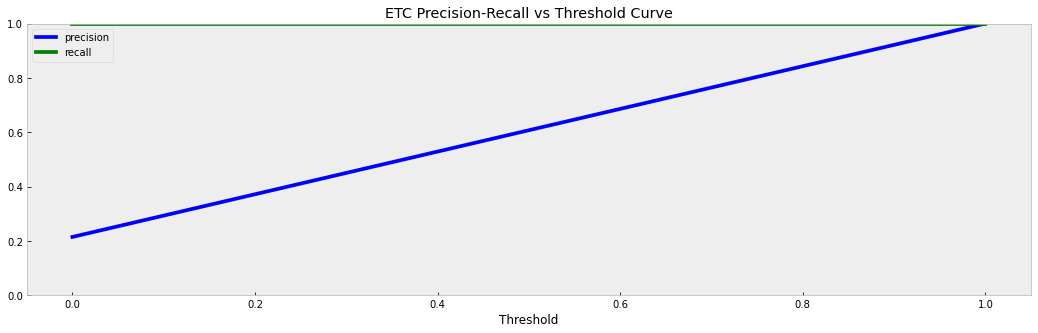

In [274]:
"""Function for plotting precision-recall vs threshold curve."""
def plotPrecisionRecallVsThresholdCurve(model, title):
    """Plots precision-recall vs threshold curve for a model."""

    probablity = model.predict_proba(xTrain)[:, 1]
    plt.figure(figsize = (18, 5))
    precision, recall, threshold = precision_recall_curve(yTrain, probablity)
    plt.plot(threshold, precision[:-1], "b-", label = "precision", lw = 3.7)
    plt.plot(threshold, recall[:-1], "g", label = "recall", lw = 3.7)
    plt.xlabel("Threshold")
    plt.legend(loc = "best")
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()

"""Now plot precision-recall vs threshold curve for the models."""

plotPrecisionRecallVsThresholdCurve(rf, title = "RF Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(xgbc, title = "XGBC Precision-Recall vs Threshold Curve")
plotPrecisionRecallVsThresholdCurve(abc, title = "ABC Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(gnb, title = "GNB Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(gbc, title = "GBC Precision-Recall vs Threshold Curve")
#plotPrecisionRecallVsThresholdCurve(svc, title = "SVC Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(knn, title = "KNN Precision-Recall vs Threshold Curve")
plotPrecisionRecallVsThresholdCurve(dt, title = "DT Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(etc, title = "ETC Precision-Recall vs Threshold Curve")

We can see for RF, the recall falls quickly at a precision of around 84%. So therefore, we need to select the precision-recall tradeoff before 84% of precision which could be at around 82%. Now, for example, if we want a precision of 80% off RF we would need a threshold of around 0.4

On the other hand, for GBC, the recall falls fast at a precision of around 84% and hence we would select precision-recall tradeoff at around 80% of precision. If we want a precision of around 81% off GBC, we would need a threshold of around 0.38

#### 4.12 Precision-Recall Curve

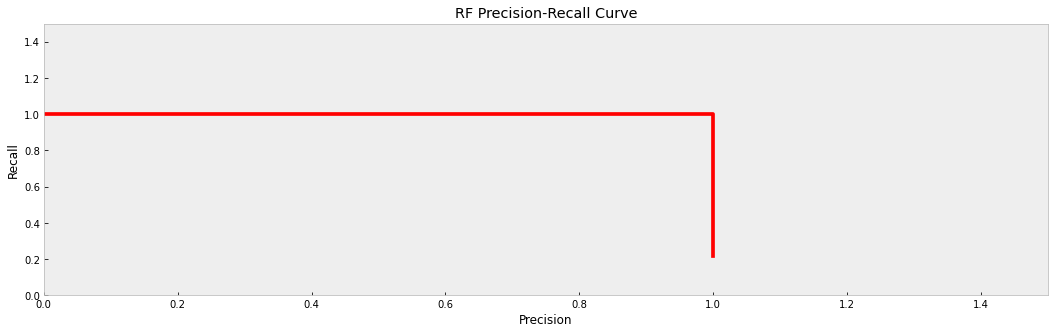

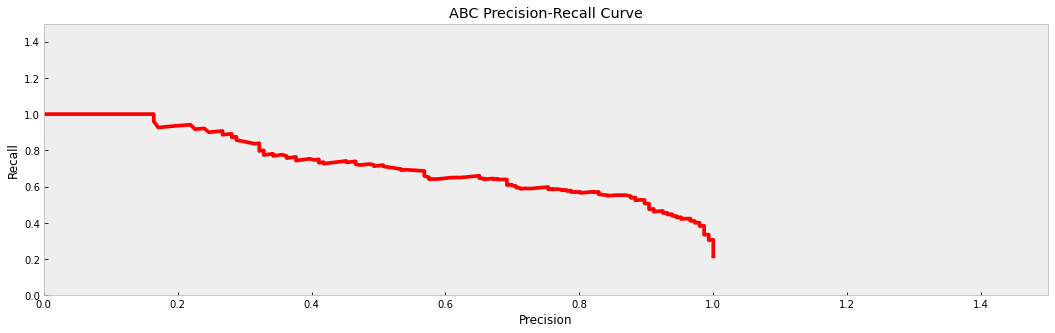

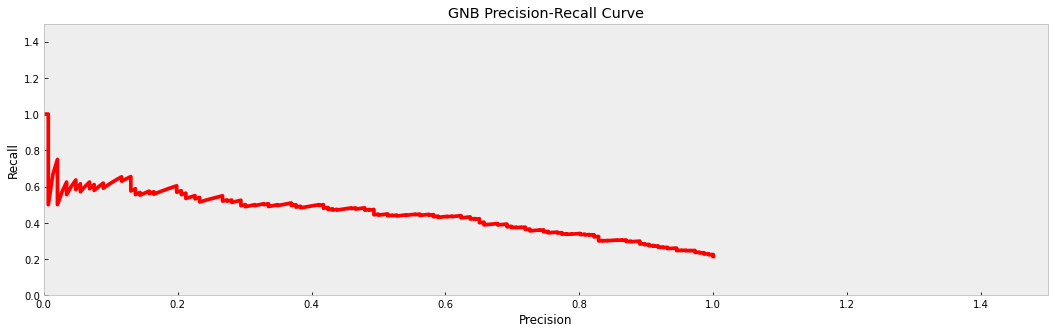

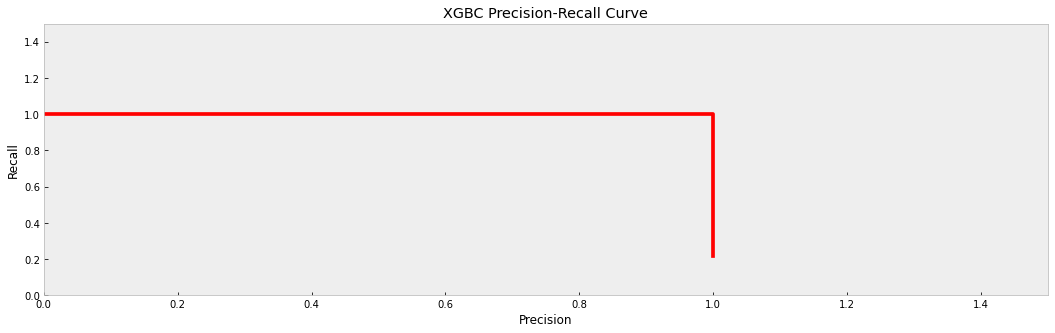

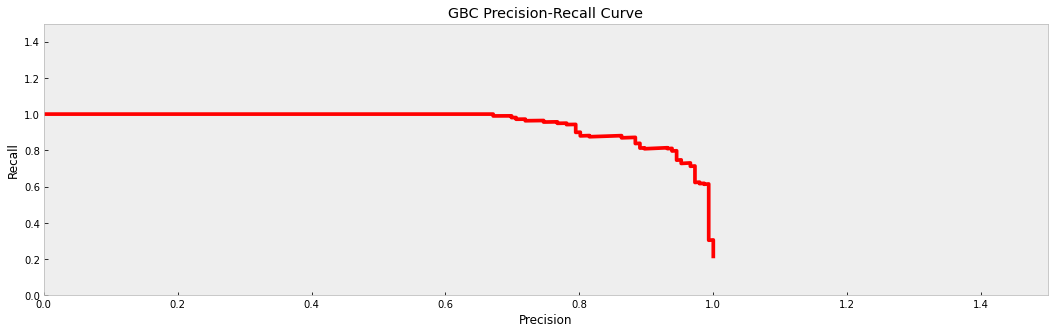

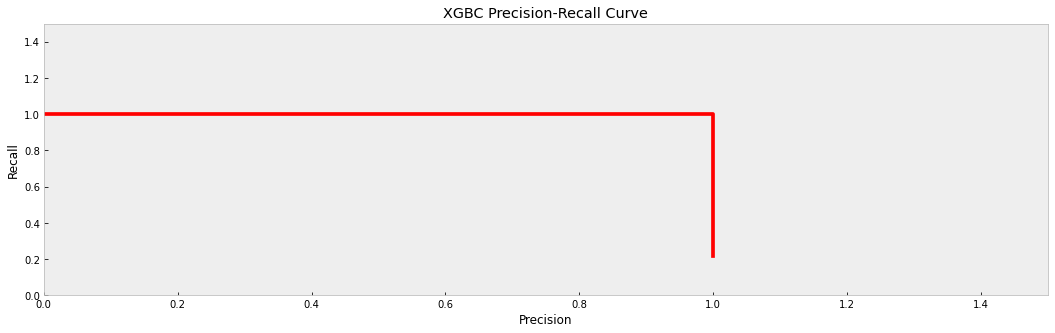

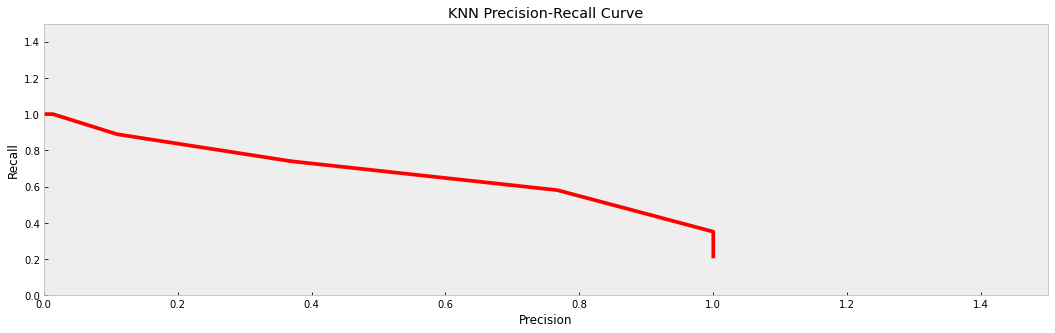

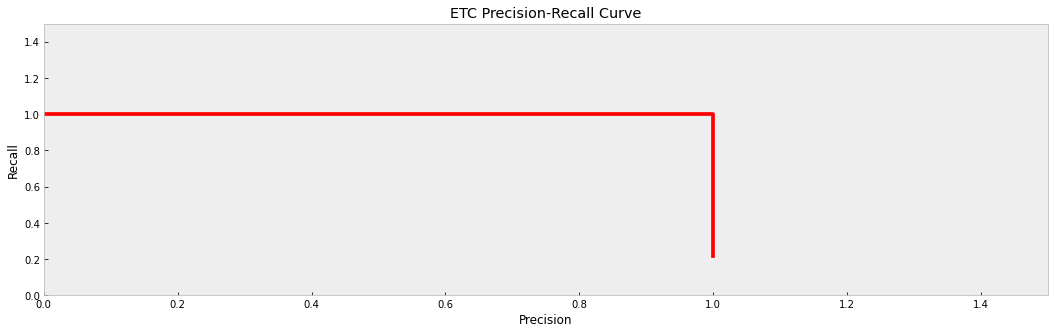

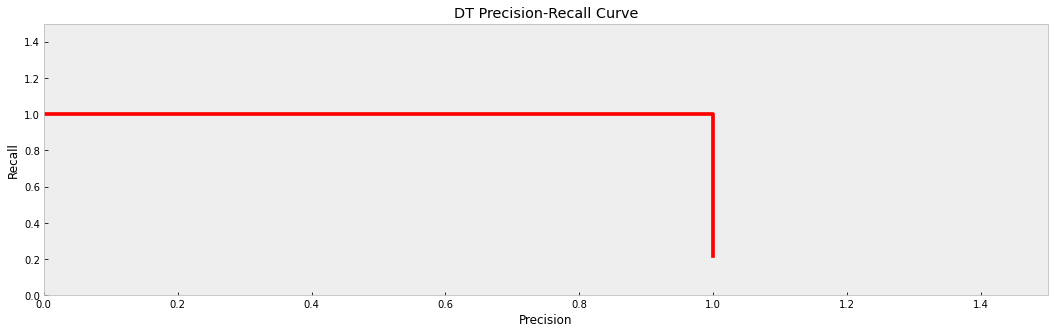

In [275]:
"""Function to plot recall vs precision curve."""
def plotPrecisionVsRecallCurve(model, title):
    """Return amodel's recall vs precision curve."""
    
    probablity = model.predict_proba(xTrain)[:, 1]
    plt.figure(figsize = (18, 5))
    precision, recall, threshold = precision_recall_curve(yTrain, probablity)
    plt.plot(recall, precision, "r-", lw = 3.7)
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.axis([0, 1.5, 0, 1.5])
    plt.title(title)
    plt.show()

"""Now plot recall vs precision curve of rf and gbc."""
plotPrecisionVsRecallCurve(rf, title = "RF Precision-Recall Curve")
plotPrecisionVsRecallCurve(abc, title = "ABC Precision-Recall Curve")
plotPrecisionVsRecallCurve(gnb, title = "GNB Precision-Recall Curve")
plotPrecisionVsRecallCurve(xgbc, title = "XGBC Precision-Recall Curve")
plotPrecisionVsRecallCurve(gbc, title = "GBC Precision-Recall Curve")
plotPrecisionVsRecallCurve(xgbc, title = "XGBC Precision-Recall Curve")
#plotPrecisionVsRecallCurve(svc, title = "svc Precision-Recall Curve")
plotPrecisionVsRecallCurve(knn, title = "KNN Precision-Recall Curve")
plotPrecisionVsRecallCurve(etc, title = "ETC Precision-Recall Curve")
plotPrecisionVsRecallCurve(dt, title = "DT Precision-Recall Curve")

We can see recall falls rapidly at around a precision of 0.84 for both RF and 0.82 for GBC that we've observed in the previous section

#### 4.13 ROC Curve & AUC Score

ROC (Reicever Operating Characteristic Curve) is a plot of the true positive rate against the false positive rate of a classifier. It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity). AUC (Area under the ROC Curve) score is the corresponding score to the AUC Curve. It is simply computed by measuring the area under the ROC curve, which is called AUC. We will plot ROC curve and AUC score together for our two classifiers.

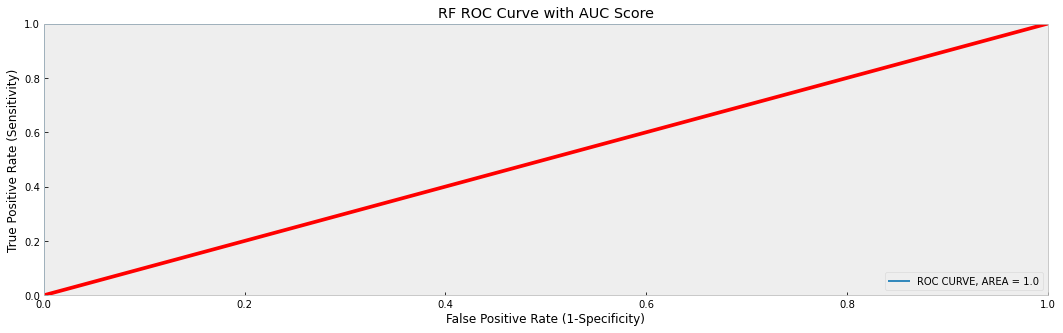

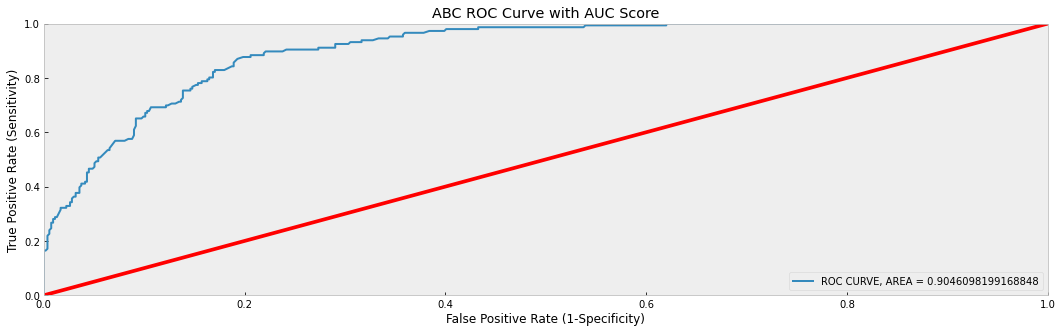

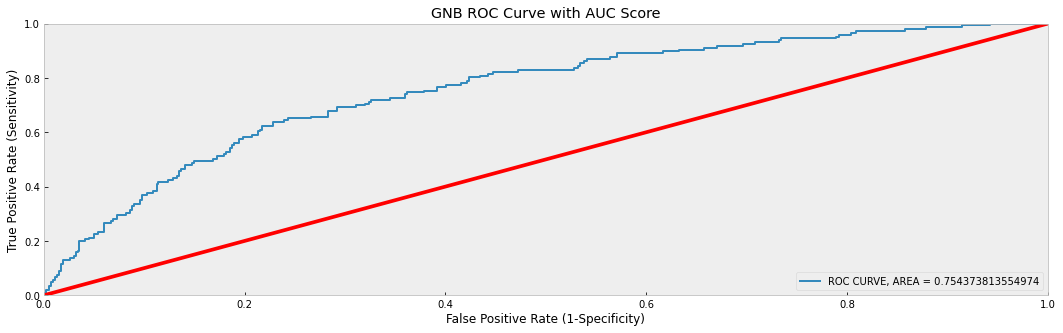

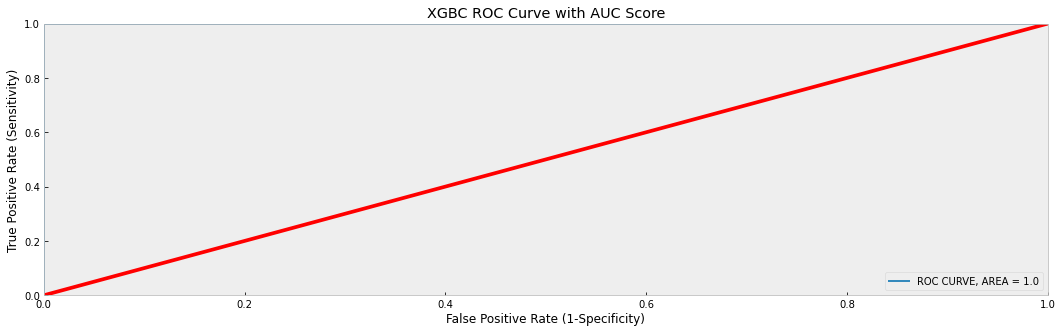

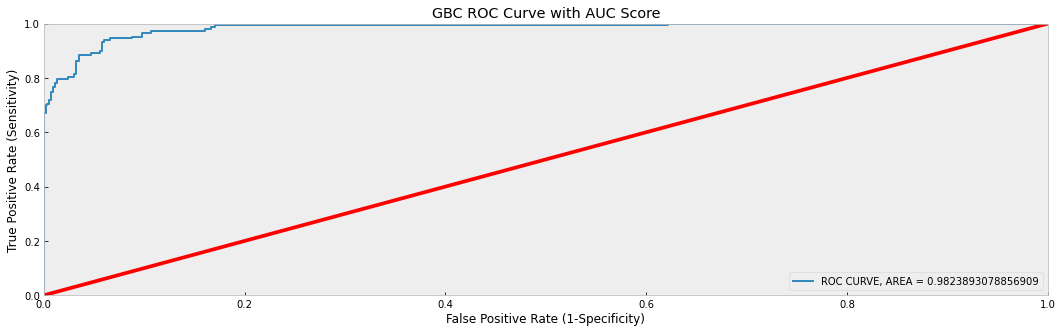

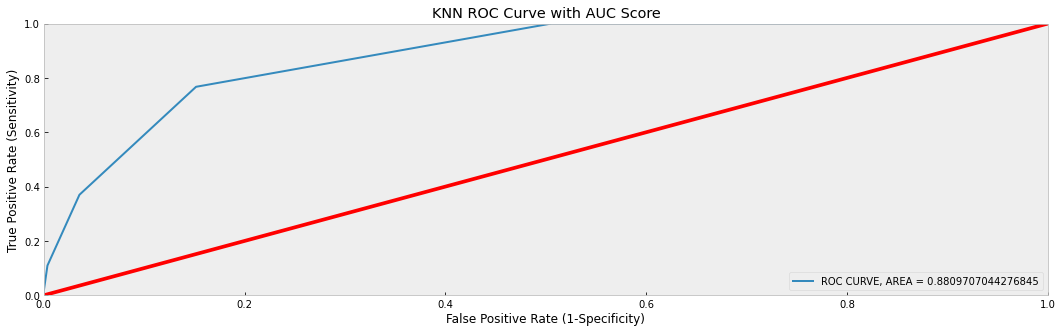

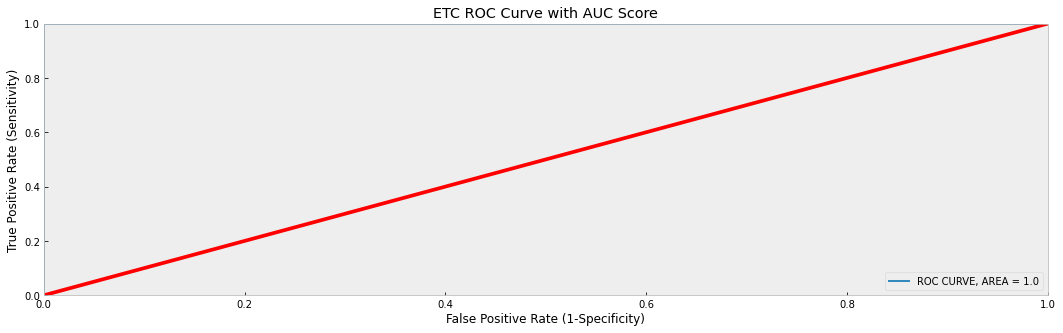

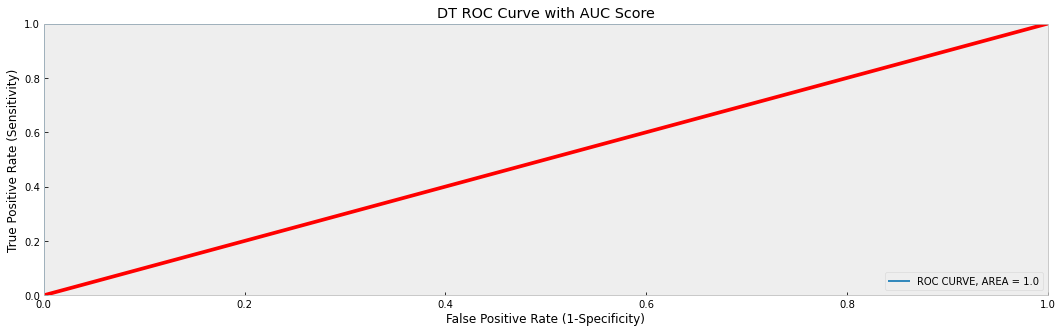

In [276]:
"""Function to plot ROC curve with AUC score."""
def plotRocAndAucScore(model, title):
    """Returns roc and auc score of a model."""
    
    probablity = model.predict_proba(xTrain)[:, 1]
    plt.figure(figsize = (18, 5))
    false_positive_rate, true_positive_rate, threshold = roc_curve(yTrain, probablity)
    auc_score = roc_auc_score(yTrain, probablity)
    plt.plot(false_positive_rate, true_positive_rate, label = "ROC CURVE, AREA = "+ str(auc_score))
    plt.plot([0, 1], [0, 1], "red", lw = 3.7)
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.axis([0, 1, 0, 1])
    plt.legend(loc = 4)
    plt.title(title)
    plt.show()

"""Plot roc curve and auc score for the models."""
plotRocAndAucScore(rf, title = "RF ROC Curve with AUC Score")
plotRocAndAucScore(abc, title = "ABC ROC Curve with AUC Score")
plotRocAndAucScore(gnb, title = "GNB ROC Curve with AUC Score")
plotRocAndAucScore(xgbc, title = "XGBC ROC Curve with AUC Score")
plotRocAndAucScore(gbc, title = "GBC ROC Curve with AUC Score")
plotRocAndAucScore(knn, title = "KNN ROC Curve with AUC Score")
plotRocAndAucScore(etc, title = "ETC ROC Curve with AUC Score")
plotRocAndAucScore(dt, title = "DT ROC Curve with AUC Score")

This two plots tells few different things:

A model that predicts at chance will have an ROC curve that looks like the diagonal red line. That is not a discriminating model.

The further the curve is off the diagonal red line, the better the model is at discriminating between positives and negatives in general.

There are useful statistics that can be calculated from this curve, like the Area Under the Curve (AUC). This tells you how well the model predicts and the optimal cut point for any given model (under specific circumstances).

Comparing the two ROC curves, we can see the distance between blue and red line of RF is greater than the distance between blue and red line of GBC. Hence it can safely be said that RF, in general, is better at discriminating between positives and negatives than GBC. Also RF(92.11%) auc score (which is the area under the roc curve) is greater than gbc(91.94%). It seems the higher the area, the further the classifier is off the red diagonal line and vice versa and hence more accurate. Since RF has more area under the ROC curve than GBC, RF is more accurate.

In [277]:
"""Make prediction using all the trained models."""
modelPrediction = pd.DataFrame({"RF":rf.predict(xTest),
                                 "GBC":gbc.predict(xTest),
                                 "ABC":abc.predict(xTest),
                                 "ETC":etc.predict(xTest), 
                                 "DT":dt.predict(xTest),
                                 "SVC":svc.predict(xTest), 
                                 "KNN":knn.predict(xTest), 
                                 "LR":lr.predict(xTest)
                                })


**All the Base Models Prediction:**

RF  GBC  ABC  ETC  DT  SVC  KNN  LR
0   0    0    0    0   0    0    0   0
1   0    0    0    0   0    0    0   0
2   0    0    0    0   0    0    0   0
3   0    0    0    0   1    0    0   0
4   0    0    0    0   0    0    0   0

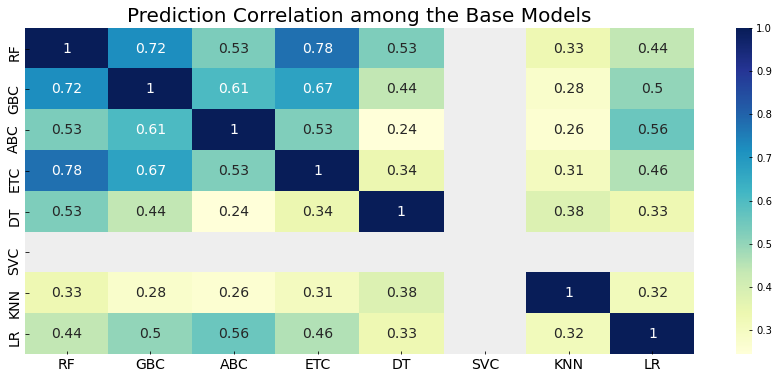

In [278]:
"""Make prediction using all the trained models."""
modelPrediction = pd.DataFrame({"RF":rf.predict(xTest),
                                 "GBC":gbc.predict(xTest),
                                 "ABC":abc.predict(xTest),
                                 "ETC":etc.predict(xTest), 
                                 "DT":dt.predict(xTest),
                                 "SVC":svc.predict(xTest), 
                                 "KNN":knn.predict(xTest), 
                                 "LR":lr.predict(xTest)
                                })


"""Create a data frame to store base models prediction.
First 5 in the dataframe are tree based models. Then two are kernel based. 
And the last is a linear model."""
basePrediction = modelPrediction # We"ve a df of all the models prediction.

"""Let"s see how each model classifies a prticular class."""
bold("All the Base Models Prediction:")
display(basePrediction.head())

"""Let"s visualize the correlations among the predictions of base models."""
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.heatmap(basePrediction.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Prediction Correlation among the Base Models", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
ax.tick_params(axis = "both", which = "minor", labelsize = 14)

## 5.  Feature Engeniering with Resampling

#### 5.1  Feature Engeniering with UNDERSAMPLING using SMOTE

In [279]:
print("Before overSampling, counts of label '1': {}".format(sum(yTrain == 1)))
print("Before overSampling, counts of label '0': {} \n".format(sum(yTrain == 0)))


Before overSampling, counts of label '1': 146
Before overSampling, counts of label '0': 534 



In [280]:
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

In [281]:
xTraino, yTraino = sm.fit_sample(X_train, y_train.ravel())

In [282]:

print('After OverSampling, the shape of xTrain: {}'.format(xTraino.shape))
print('After OverSampling, the shape of yTrain: {} \n'.format(yTraino.shape))


After OverSampling, the shape of xTrain: (1068, 7)
After OverSampling, the shape of yTrain: (1068,) 



In [283]:
print("After OverSampling, counts of label '1': {}".format(sum(yTraino == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(yTraino == 0)))

After OverSampling, counts of label '1': 534
After OverSampling, counts of label '0': 534


Now both categories have the same amount of values as the majority class. We will now proceed with the ML algorithm.

In [284]:
"""Create a function that returns train accuracy of different models."""
def calculateTrainAccuracy(model):
    """Returns training accuracy of a model."""
    
    model.fit(xTraino, yTraino)
    trainAccuracy = model.score(xTraino, yTraino)
    trainAccuracy = round(trainAccuracy*100, 2)
    return trainAccuracy

# Calculate train accuracy of all the models and store them in a dataframe
modelScores = list(map(calculateTrainAccuracy, models))
trainAccuracy = pd.DataFrame(modelScores, columns = ["trainAccuracy"], index=modelNames)
trainAccuracySorted = trainAccuracy.sort_values(by="trainAccuracy", ascending=False)
bold("Training Accuracy of the Classifiers:")
display(trainAccuracySorted)

**Training Accuracy of the Classifiers:**

trainAccuracy
RF           100.00
DT           100.00
ETC          100.00
XGBC         100.00
GBC           89.89
KNN           83.90
ABC           79.78
LR            72.85
SVC           72.00
GNB           67.79

In [285]:
"""Create a function that returns mean cross validation score for different models."""
def calculateXValScore(model):
    """Returns models' cross validation scores."""
    
    xValScore = cross_val_score(model, xTraino, yTraino, cv = 10, scoring="accuracy").mean()
    xValScore = round(xValScore*100, 2)
    return xValScore

# Calculate cross validation scores of all the models and store them in a dataframe
modelScores = list(map(calculateXValScore, models))
xValScores = pd.DataFrame(modelScores, columns = ["xValScore"], index=modelNames)
xValScoresSorted = xValScores.sort_values(by="xValScore", ascending=False)
bold("Models 10-fold Cross Validation Score:")
display(xValScoresSorted)

**Models 10-fold Cross Validation Score:**

xValScore
RF        83.23
ETC       83.05
XGBC      82.77
GBC       79.39
KNN       77.81
DT        76.50
ABC       73.97
LR        72.29
SVC       71.35
GNB       67.23

In [286]:
"""Return prediction to use it in another function."""
def xValPredict(model):
    """Returns prediction by which we can calculate different classification metrics."""
    
    predicted = cross_val_predict(model, xTraino, yTraino, cv = 10)
    return predicted # Now we can use it in another function by assigning the function to its return value.

"""Function to return confusion matrix."""
def calculateConfusionMatrix(model):
    """returns a models confusion matrix"""
    
    predicted = xValPredict(model)
    confusionMatrix = pd.crosstab(yTraino, predicted, rownames = ["Actual"],
                                   colnames = ["Predicted/Classified"], margins = True)
    return display(confusionMatrix)

"""Now calculate confusion matrix of the models."""
bold("ETC Confusion Matrix:")
calculateConfusionMatrix(etc)
bold("RF Confusion Matrix:")
calculateConfusionMatrix(rf)
bold("GBC Confusion Matrix:")
calculateConfusionMatrix(gbc)
bold("XGBC Confusion Matrix:")
calculateConfusionMatrix(xgbc)
bold("ABC Confusion Matrix:")
calculateConfusionMatrix(abc)
bold("GNB Confusion Matrix:")
calculateConfusionMatrix(gnb)
bold("SVC Confusion Matrix:")
calculateConfusionMatrix(svc)
bold("KNN Confusion Matrix:")
calculateConfusionMatrix(knn)
bold("DT Confusion Matrix:")
calculateConfusionMatrix(dt)

**ETC Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     421  113   534
1                      68  466   534
All                   489  579  1068

**RF Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     426  108   534
1                      71  463   534
All                   497  571  1068

**GBC Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     403  131   534
1                      89  445   534
All                   492  576  1068

**XGBC Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     422  112   534
1                      72  462   534
All                   494  574  1068

**ABC Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     389  145   534
1                     133  401   534
All                   522  546  1068

**GNB Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     333  201   534
1                     149  385   534
All                   482  586  1068

**SVC Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     387  147   534
1                     159  375   534
All                   546  522  1068

**KNN Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     369  165   534
1                      72  462   534
All                   441  627  1068

**DT Confusion Matrix:**

Predicted/Classified    0    1   All
Actual                              
0                     389  145   534
1                     106  428   534
All                   495  573  1068

In [287]:
"""Function to calculate precision score."""
def calculatePrecisionScore(model):
    """Calculates a model's precision score."""
    
    predicted = xValPredict(model)
    precisionScore = precision_score(yTraino, predicted)
    return round(precisionScore*100, 2)

"""Compute precision score for rf and gbc."""
print(f"RF  Precision Score: {calculatePrecisionScore(rf)}")
print(f"XGBC Precision Score: {calculatePrecisionScore(xgbc)}")
print(f"ABC  Precision Score: {calculatePrecisionScore(abc)}")
print(f"GBC Precision Score: {calculatePrecisionScore(gbc)}")
print(f"GNB  Precision Score: {calculatePrecisionScore(gnb)}")
#print(f"SVC Precision Score: {calculatePrecisionScore(svc)}")
print(f"KNN  Precision Score: {calculatePrecisionScore(knn)}")
print(f"DT Precision Score: {calculatePrecisionScore(dt)}")
print(f"ETC Precision Score: {calculatePrecisionScore(etc)}")

RF  Precision Score: 81.09
XGBC Precision Score: 80.49
ABC  Precision Score: 73.44
GBC Precision Score: 77.26
GNB  Precision Score: 65.7
KNN  Precision Score: 73.68
DT Precision Score: 74.69
ETC Precision Score: 80.48


In [288]:
"""Function to calculate recall score."""
def calculateRecallScore(model):
    """Calculate a model's recall score."""
    
    predicted = xValPredict(model)
    recallScore = recall_score(yTraino, predicted)
    return round(recallScore*100, 2)

"""Compute Recall score for rf and gbc."""
print(f"RF  Recall Score: {calculateRecallScore(rf)}")
print(f"XGBC Recall Score: {calculateRecallScore(xgbc)}")
print(f"ABC  Recall Score: {calculateRecallScore(abc)}")
print(f"GBC Recall Score: {calculateRecallScore(gbc)}")
print(f"GNB  Recall Score: {calculateRecallScore(gnb)}")
#print(f"SVC Recall Score: {calculateRecallScore(svc)}")
print(f"KNN  Recall Score: {calculateRecallScore(knn)}")
print(f"DT Recall Score: {calculateRecallScore(dt)}")
print(f"ETC Recall Score: {calculateRecallScore(etc)}")

RF  Recall Score: 86.7
XGBC Recall Score: 86.52
ABC  Recall Score: 75.09
GBC Recall Score: 83.33
GNB  Recall Score: 72.1
KNN  Recall Score: 86.52
DT Recall Score: 80.15
ETC Recall Score: 87.27


In [289]:
"""Function for specificity score."""
def calculateSpecificityScore(model):
    """Returns a model's specificity score."""
    
    predicted = xValPredict(model)
    tn, fp, fn, tp = confusion_matrix(yTraino, predicted).ravel()
    specificityScore = tn / (tn + fp)
    return round(specificityScore*100, 2)

"""Calculate specificity score for the models."""
print(f"RF  Specificity Score: {calculateSpecificityScore(rf)}")
print(f"XGBC Specificity Score: {calculateSpecificityScore(xgbc)}")
print(f"ABC  Specificity Score: {calculateSpecificityScore(abc)}")
print(f"GBC Specificity Score: {calculateSpecificityScore(gbc)}")
print(f"GNB  Specificity Score: {calculateSpecificityScore(gnb)}")
#print(f"SVC Specificity Score: {calculateSpecificityScore(svc)}")
print(f"KNN  Specificity Score: {calculateSpecificityScore(knn)}")
print(f"DT Specificity Score: {calculateSpecificityScore(dt)}")
print(f"ETC Specificity Score: {calculateSpecificityScore(etc)}")

RF  Specificity Score: 79.78
XGBC Specificity Score: 79.03
ABC  Specificity Score: 72.85
GBC Specificity Score: 75.47
GNB  Specificity Score: 62.36
KNN  Specificity Score: 69.1
DT Specificity Score: 72.85
ETC Specificity Score: 78.84


In [290]:
"""Function for F1 score."""
def calculateF1Score(model):
    """Returns a model's f1 score."""
    
    predicted = xValPredict(model)
    f1Score = f1_score(yTraino, predicted)
    return round(f1Score*100, 2)

"""Calculate f1 score for models."""
print(f"RF  F1 Score: {calculateF1Score(rf)}")
print(f"XGBC F1 Score: {calculateF1Score(xgbc)}")
print(f"ABC  F1 Score: {calculateF1Score(abc)}")
print(f"GBC F1 Score: {calculateF1Score(gbc)}")
print(f"GNB  F1 Score: {calculateF1Score(gnb)}")
#print(f"SVC F1 Score: {calculateF1Score(svc)}")
print(f"KNN  F1 Score: {calculateF1Score(knn)}")
print(f"DT F1 Score: {calculateF1Score(dt)}")
print(f"ETC F1 Score: {calculateF1Score(etc)}")

RF  F1 Score: 83.8
XGBC F1 Score: 83.39
ABC  F1 Score: 74.26
GBC F1 Score: 80.18
GNB  F1 Score: 68.75
KNN  F1 Score: 79.59
DT F1 Score: 77.33
ETC F1 Score: 83.74


In [291]:
"""Function to compute classification report."""
def calculateClassificationReport(model):
    """Returns a model"s classification report."""
    
    predicted = xValPredict(model)
    classificationReport = classification_report(yTraino, predicted)
    return print(classificationReport)

"""Now calculate classification report for the models."""
bold("RF Classification Report:")
calculateClassificationReport(rf)
bold("XGBC Classification Report:")
calculateClassificationReport(xgbc)
bold("ABC Classification Report:")
calculateClassificationReport(abc)
bold("GBC Classification Report:")
calculateClassificationReport(gbc)
bold("GNB Classification Report:")
calculateClassificationReport(gnb)
bold("SVC Classification Report:")
calculateClassificationReport(svc)
bold("KNN Classification Report:")
calculateClassificationReport(knn)
bold("DT Classification Report:")
calculateClassificationReport(dt)
bold("ETC Classification Report:")
calculateClassificationReport(etc)

**RF Classification Report:**

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       534
           1       0.81      0.87      0.84       534

    accuracy                           0.83      1068
   macro avg       0.83      0.83      0.83      1068
weighted avg       0.83      0.83      0.83      1068



**XGBC Classification Report:**

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       534
           1       0.80      0.87      0.83       534

    accuracy                           0.83      1068
   macro avg       0.83      0.83      0.83      1068
weighted avg       0.83      0.83      0.83      1068



**ABC Classification Report:**

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       534
           1       0.73      0.75      0.74       534

    accuracy                           0.74      1068
   macro avg       0.74      0.74      0.74      1068
weighted avg       0.74      0.74      0.74      1068



**GBC Classification Report:**

              precision    recall  f1-score   support

           0       0.82      0.75      0.79       534
           1       0.77      0.83      0.80       534

    accuracy                           0.79      1068
   macro avg       0.80      0.79      0.79      1068
weighted avg       0.80      0.79      0.79      1068



**GNB Classification Report:**

              precision    recall  f1-score   support

           0       0.69      0.62      0.66       534
           1       0.66      0.72      0.69       534

    accuracy                           0.67      1068
   macro avg       0.67      0.67      0.67      1068
weighted avg       0.67      0.67      0.67      1068



**SVC Classification Report:**

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       534
           1       0.72      0.70      0.71       534

    accuracy                           0.71      1068
   macro avg       0.71      0.71      0.71      1068
weighted avg       0.71      0.71      0.71      1068



**KNN Classification Report:**

              precision    recall  f1-score   support

           0       0.84      0.69      0.76       534
           1       0.74      0.87      0.80       534

    accuracy                           0.78      1068
   macro avg       0.79      0.78      0.78      1068
weighted avg       0.79      0.78      0.78      1068



**DT Classification Report:**

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       534
           1       0.75      0.80      0.77       534

    accuracy                           0.76      1068
   macro avg       0.77      0.76      0.76      1068
weighted avg       0.77      0.76      0.76      1068



**ETC Classification Report:**

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       534
           1       0.80      0.87      0.84       534

    accuracy                           0.83      1068
   macro avg       0.83      0.83      0.83      1068
weighted avg       0.83      0.83      0.83      1068



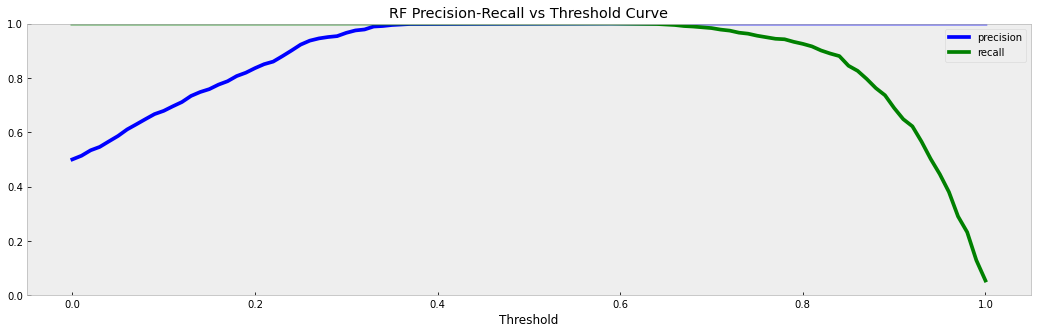

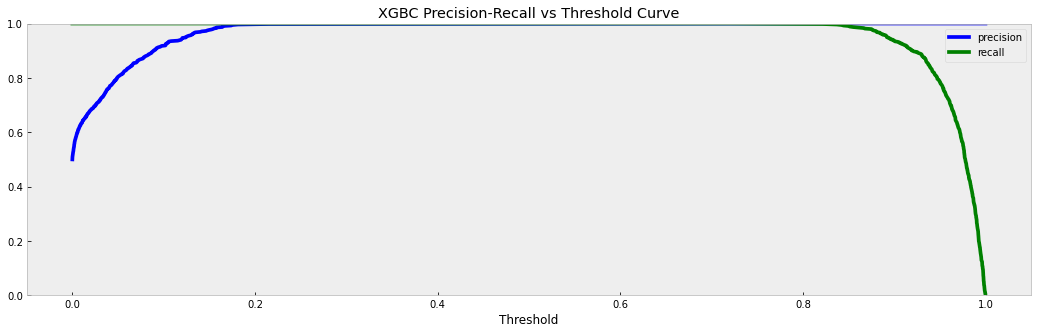

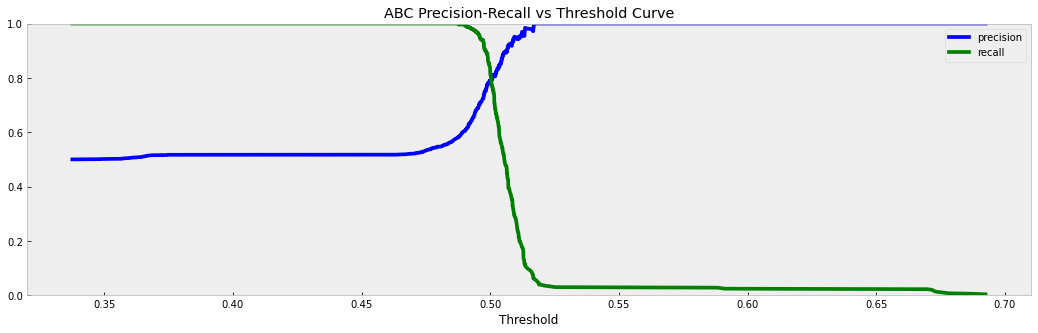

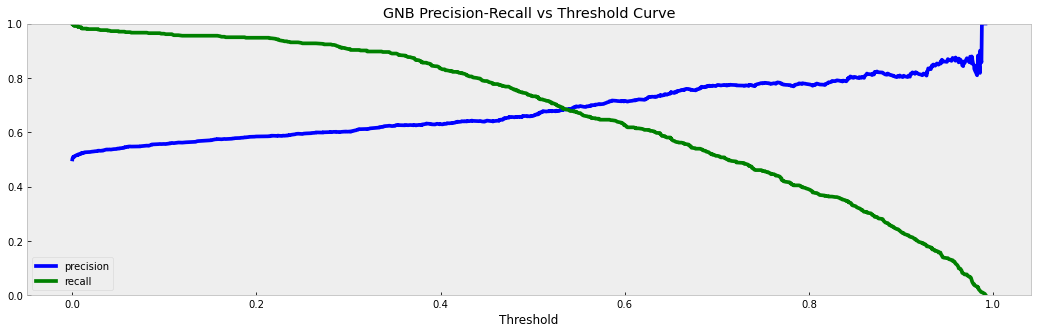

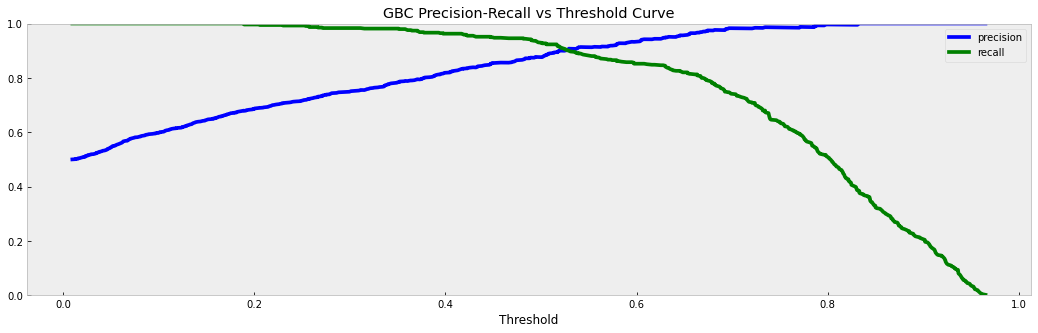

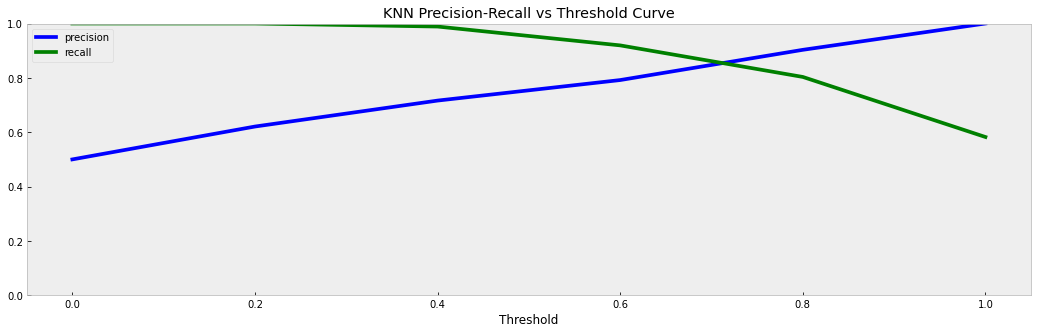

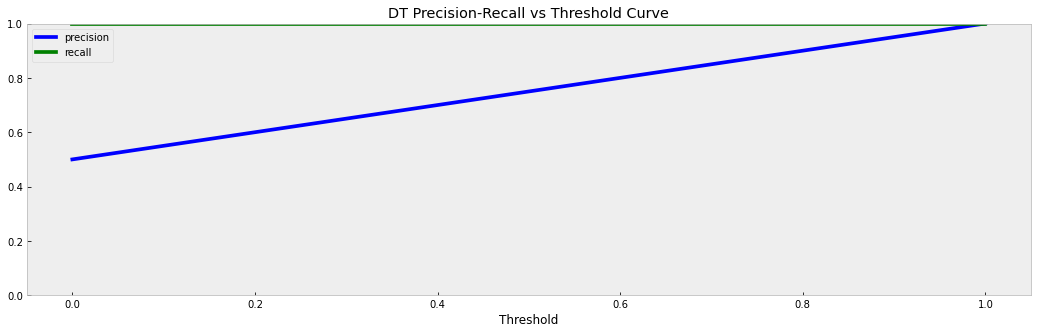

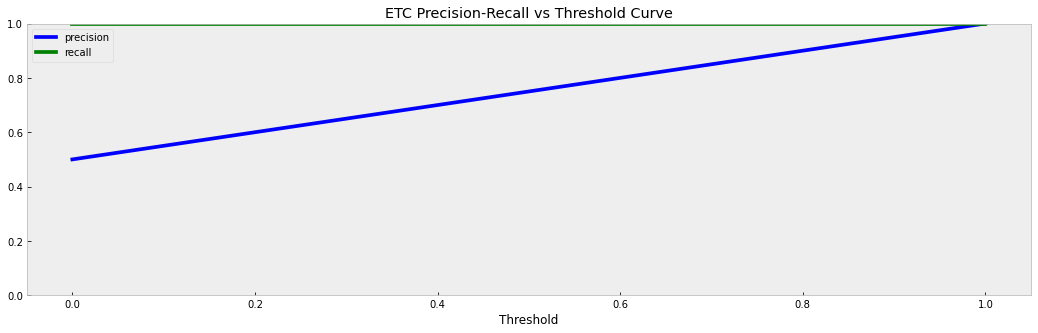

In [294]:
"""Function for plotting precision-recall vs threshold curve."""
def plotPrecisionRecallVsThresholdCurve(model, title):
    """Plots precision-recall vs threshold curve for a model."""

    probablity = model.predict_proba(xTraino)[:, 1]
    plt.figure(figsize = (18, 5))
    precision, recall, threshold = precision_recall_curve(yTraino, probablity)
    plt.plot(threshold, precision[:-1], "b-", label = "precision", lw = 3.7)
    plt.plot(threshold, recall[:-1], "g", label = "recall", lw = 3.7)
    plt.xlabel("Threshold")
    plt.legend(loc = "best")
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()

"""Now plot precision-recall vs threshold curve for the models."""

plotPrecisionRecallVsThresholdCurve(rf, title = "RF Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(xgbc, title = "XGBC Precision-Recall vs Threshold Curve")
plotPrecisionRecallVsThresholdCurve(abc, title = "ABC Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(gnb, title = "GNB Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(gbc, title = "GBC Precision-Recall vs Threshold Curve")
#plotPrecisionRecallVsThresholdCurve(svc, title = "SVC Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(knn, title = "KNN Precision-Recall vs Threshold Curve")
plotPrecisionRecallVsThresholdCurve(dt, title = "DT Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(etc, title = "ETC Precision-Recall vs Threshold Curve")

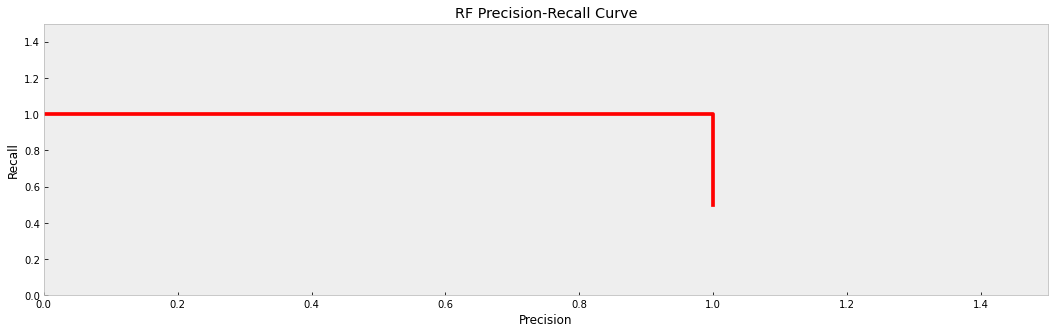

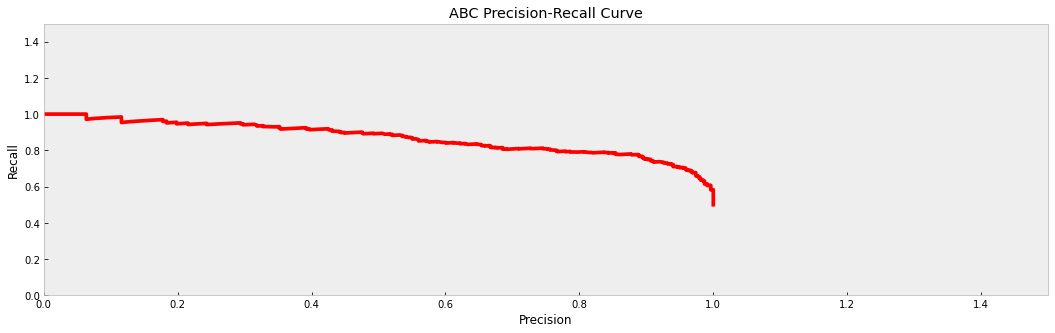

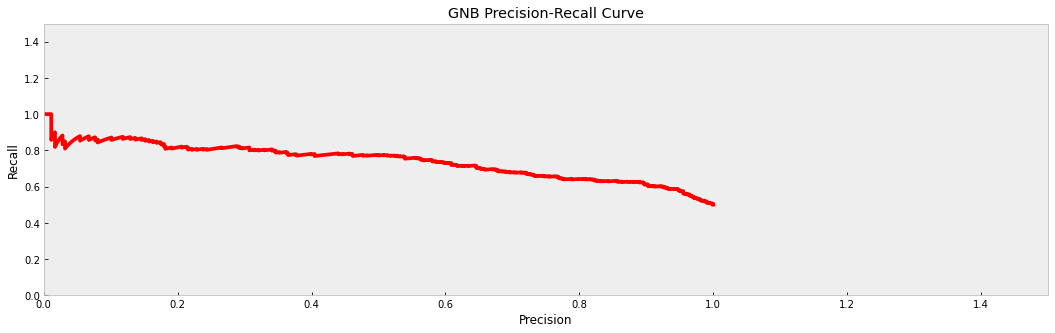

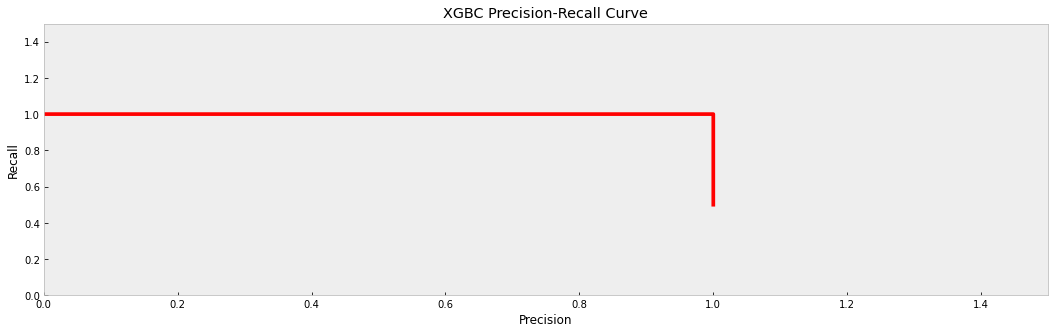

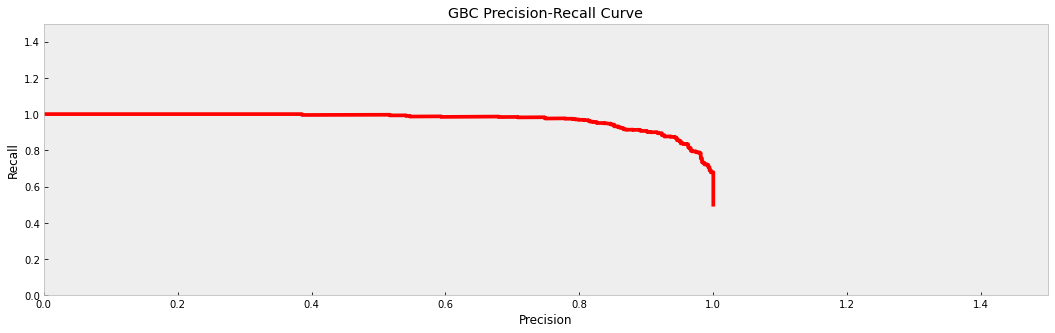

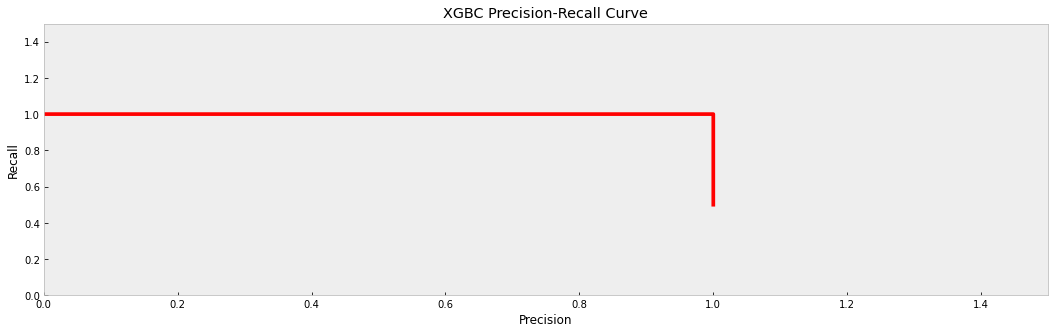

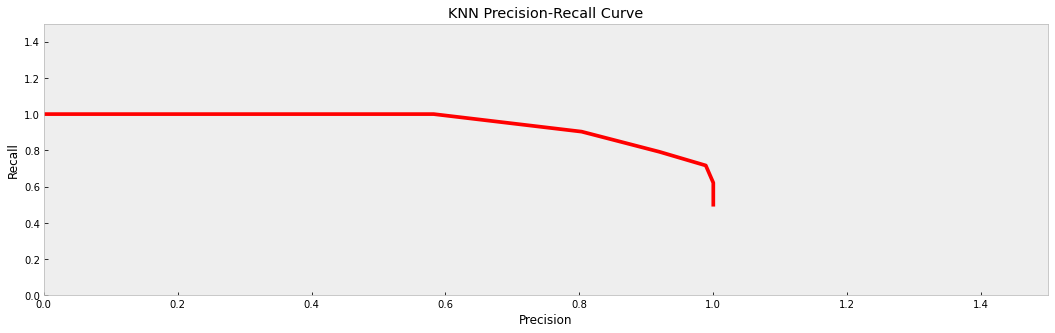

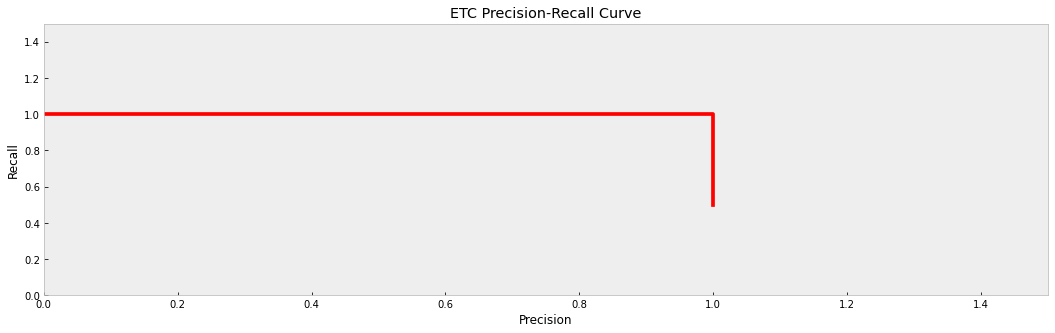

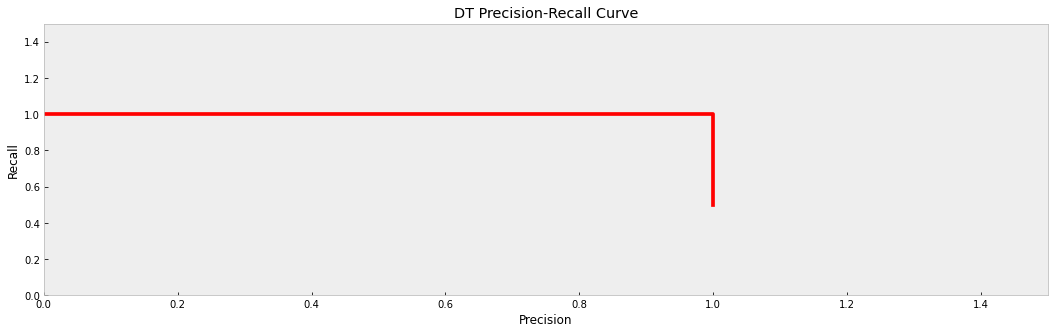

In [295]:
"""Function to plot recall vs precision curve."""
def plotPrecisionVsRecallCurve(model, title):
    """Return amodel's recall vs precision curve."""
    
    probablity = model.predict_proba(xTraino)[:, 1]
    plt.figure(figsize = (18, 5))
    precision, recall, threshold = precision_recall_curve(yTraino, probablity)
    plt.plot(recall, precision, "r-", lw = 3.7)
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.axis([0, 1.5, 0, 1.5])
    plt.title(title)
    plt.show()

"""Now plot recall vs precision curve of rf and gbc."""
plotPrecisionVsRecallCurve(rf, title = "RF Precision-Recall Curve")
plotPrecisionVsRecallCurve(abc, title = "ABC Precision-Recall Curve")
plotPrecisionVsRecallCurve(gnb, title = "GNB Precision-Recall Curve")
plotPrecisionVsRecallCurve(xgbc, title = "XGBC Precision-Recall Curve")
plotPrecisionVsRecallCurve(gbc, title = "GBC Precision-Recall Curve")
plotPrecisionVsRecallCurve(xgbc, title = "XGBC Precision-Recall Curve")
#plotPrecisionVsRecallCurve(svc, title = "svc Precision-Recall Curve")
plotPrecisionVsRecallCurve(knn, title = "KNN Precision-Recall Curve")
plotPrecisionVsRecallCurve(etc, title = "ETC Precision-Recall Curve")
plotPrecisionVsRecallCurve(dt, title = "DT Precision-Recall Curve")

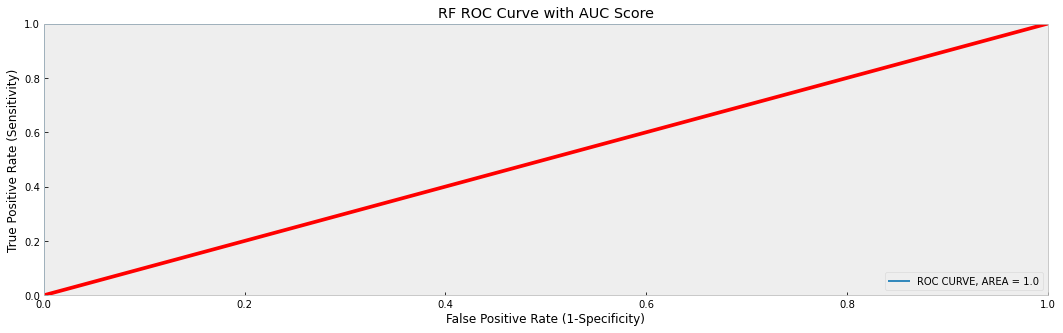

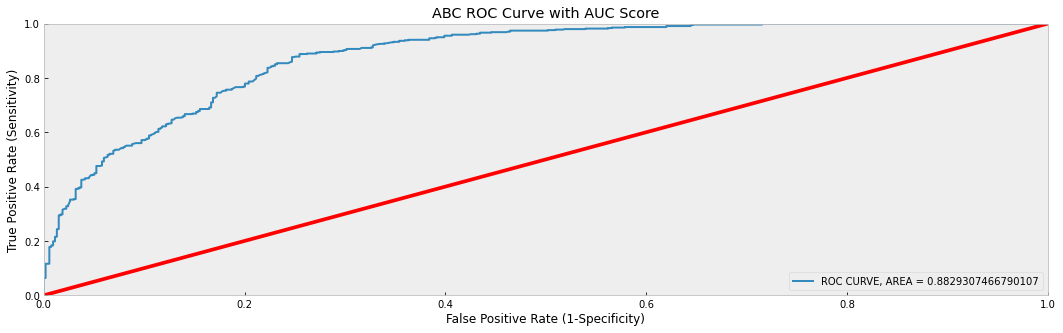

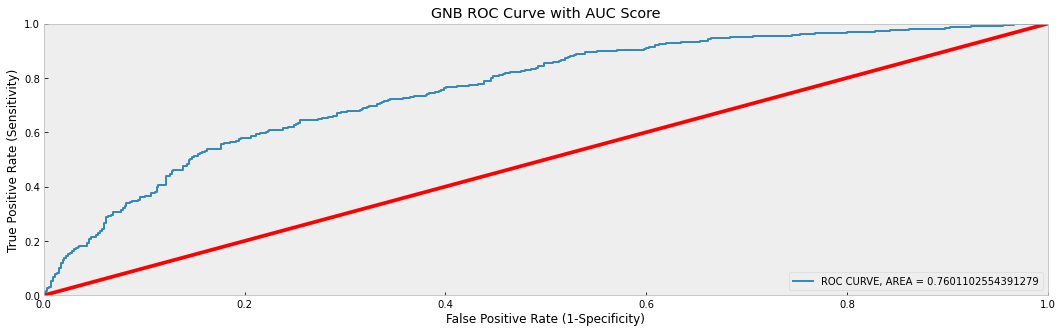

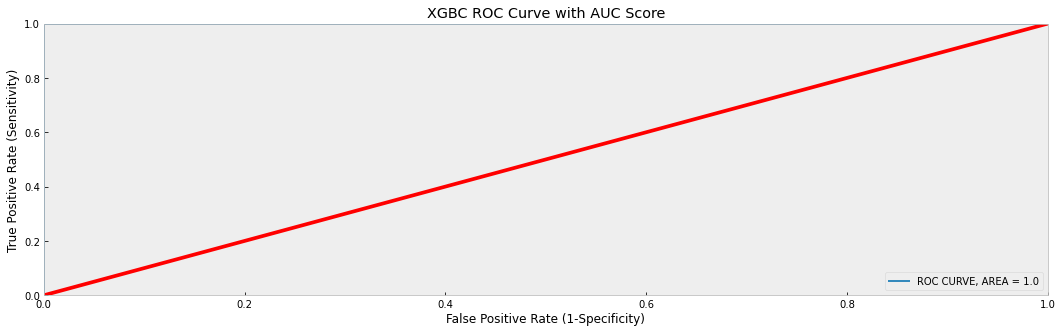

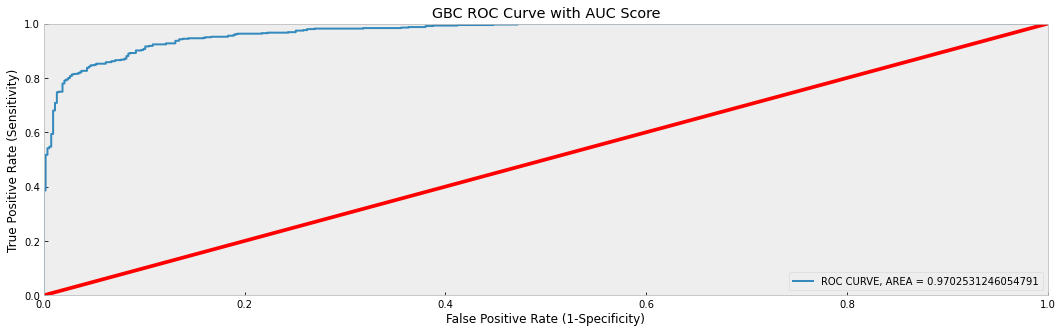

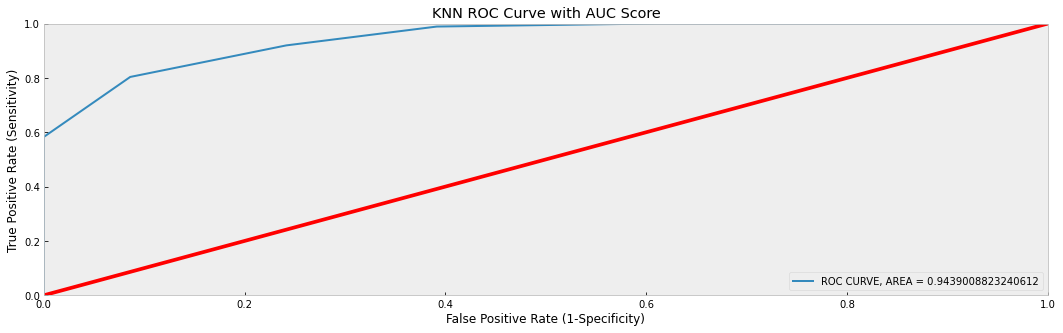

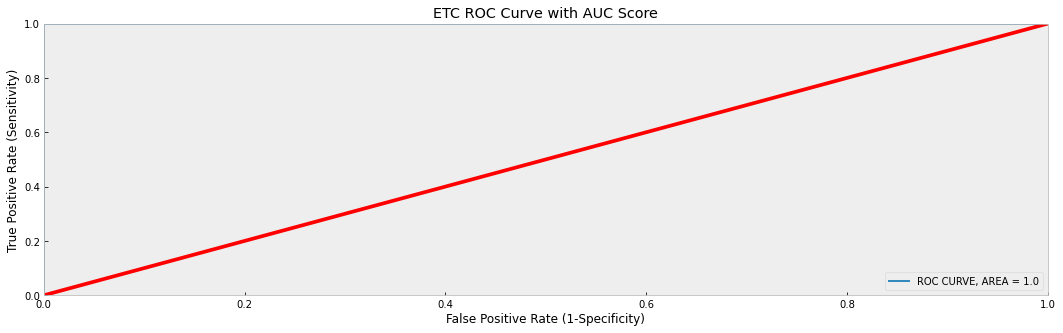

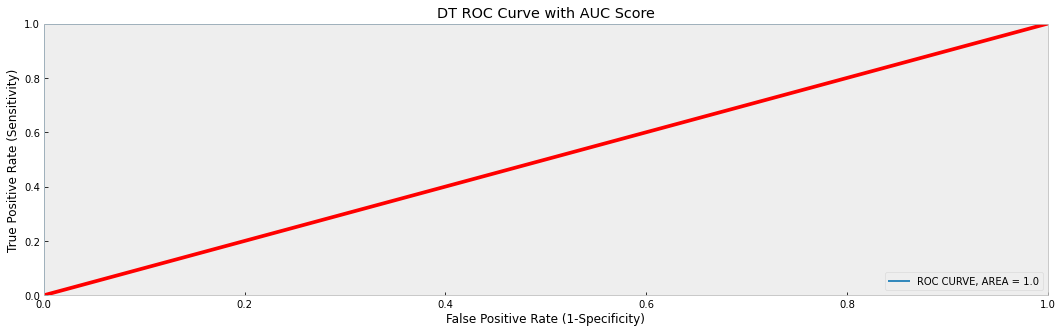

In [296]:
"""Function to plot ROC curve with AUC score."""
def plotRocAndAucScore(model, title):
    """Returns roc and auc score of a model."""
    
    probablity = model.predict_proba(xTraino)[:, 1]
    plt.figure(figsize = (18, 5))
    false_positive_rate, true_positive_rate, threshold = roc_curve(yTraino, probablity)
    auc_score = roc_auc_score(yTraino, probablity)
    plt.plot(false_positive_rate, true_positive_rate, label = "ROC CURVE, AREA = "+ str(auc_score))
    plt.plot([0, 1], [0, 1], "red", lw = 3.7)
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.axis([0, 1, 0, 1])
    plt.legend(loc = 4)
    plt.title(title)
    plt.show()

"""Plot roc curve and auc score for the models."""
plotRocAndAucScore(rf, title = "RF ROC Curve with AUC Score")
plotRocAndAucScore(abc, title = "ABC ROC Curve with AUC Score")
plotRocAndAucScore(gnb, title = "GNB ROC Curve with AUC Score")
plotRocAndAucScore(xgbc, title = "XGBC ROC Curve with AUC Score")
plotRocAndAucScore(gbc, title = "GBC ROC Curve with AUC Score")
plotRocAndAucScore(knn, title = "KNN ROC Curve with AUC Score")
plotRocAndAucScore(etc, title = "ETC ROC Curve with AUC Score")
plotRocAndAucScore(dt, title = "DT ROC Curve with AUC Score")

**All the Base Models Prediction:**

RF  GBC  ABC  ETC  DT  SVC  KNN  LR
0   0    0    0    0   0    0    0   0
1   0    0    0    0   0    0    0   0
2   0    0    0    0   0    0    0   0
3   0    0    1    0   0    1    1   1
4   0    0    0    0   1    0    1   0

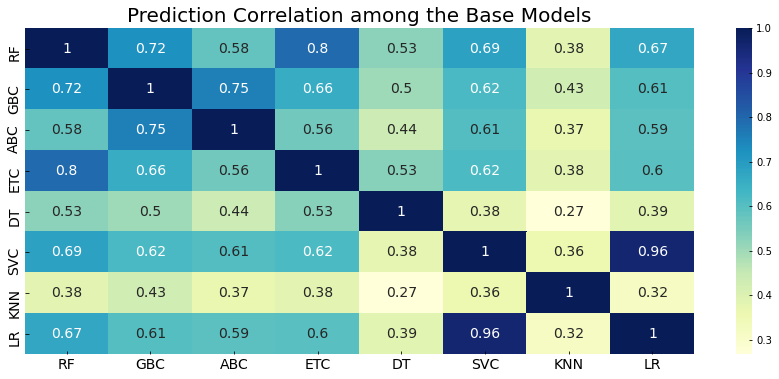

In [298]:
"""Make prediction using all the trained models."""
modelPrediction = pd.DataFrame({"RF":rf.predict(xTest),
                                 "GBC":gbc.predict(xTest),
                                 "ABC":abc.predict(xTest),
                                 "ETC":etc.predict(xTest), 
                                 "DT":dt.predict(xTest),
                                 "SVC":svc.predict(xTest), 
                                 "KNN":knn.predict(xTest), 
                                 "LR":lr.predict(xTest)
                                })


"""Create a data frame to store base models prediction.
First 5 in the dataframe are tree based models. Then two are kernel based. 
And the last is a linear model."""
basePrediction = modelPrediction # We"ve a df of all the models prediction.

"""Let"s see how each model classifies a prticular class."""
bold("All the Base Models Prediction:")
display(basePrediction.head())

"""Let"s visualize the correlations among the predictions of base models."""
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.heatmap(basePrediction.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Prediction Correlation among the Base Models", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
ax.tick_params(axis = "both", which = "minor", labelsize = 14)

#### 5.2  Feature Engeniering with UNDERSAMPLING using NearMiss

In [300]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()
# resampling X, y
xTrainu, yTrainu = nr.fit_resample(xTrain, yTrain)
# new class distribution
print(Counter(yTrainu))


Counter({0: 146, 1: 146})


In [304]:
print("After underSampling, counts of label '1': {}".format(sum(yTrainu == 1)))
print("After underSampling, counts of label '0': {}".format(sum(yTrainu == 0)))

After underSampling, counts of label '1': 146
After underSampling, counts of label '0': 146


In [305]:
"""Create a function that returns train accuracy of different models."""
def calculateTrainAccuracy(model):
    """Returns training accuracy of a model."""
    
    model.fit(xTrainu, yTrainu)
    trainAccuracy = model.score(xTrainu, yTrainu)
    trainAccuracy = round(trainAccuracy*100, 2)
    return trainAccuracy

# Calculate train accuracy of all the models and store them in a dataframe
modelScores = list(map(calculateTrainAccuracy, models))
trainAccuracy = pd.DataFrame(modelScores, columns = ["trainAccuracy"], index=modelNames)
trainAccuracySorted = trainAccuracy.sort_values(by="trainAccuracy", ascending=False)
bold("Training Accuracy of the Classifiers:")
display(trainAccuracySorted)

**Training Accuracy of the Classifiers:**

trainAccuracy
RF           100.00
DT           100.00
ETC          100.00
XGBC         100.00
GBC           97.26
ABC           82.88
KNN           72.95
LR            70.89
SVC           69.18
GNB           63.36

In [308]:
"""Create a function that returns mean cross validation score for different models."""
def calculateXValScore(model):
    """Returns models' cross validation scores."""
    
    xValScore = cross_val_score(model, xTrainu, yTrainu, cv = 10, scoring="accuracy").mean()
    xValScore = round(xValScore*100, 2)
    return xValScore

# Calculate cross validation scores of all the models and store them in a dataframe
modelScores = list(map(calculateXValScore, models))
xValScores = pd.DataFrame(modelScores, columns = ["xValScore"], index=modelNames)
xValScoresSorted = xValScores.sort_values(by="xValScore", ascending=False)
bold("Models 10-fold Cross Validation Score:")
display(xValScoresSorted)

**Models 10-fold Cross Validation Score:**

xValScore
LR        67.82
ETC       67.44
SVC       67.14
XGBC      65.40
ABC       63.36
RF        62.69
GBC       62.37
GNB       60.01
KNN       57.26
DT        53.83

In [309]:
"""Return prediction to use it in another function."""
def xValPredict(model):
    """Returns prediction by which we can calculate different classification metrics."""
    
    predicted = cross_val_predict(model, xTrainu, yTrainu, cv = 10)
    return predicted # Now we can use it in another function by assigning the function to its return value.

"""Function to return confusion matrix."""
def calculateConfusionMatrix(model):
    """returns a models confusion matrix"""
    
    predicted = xValPredict(model)
    confusionMatrix = pd.crosstab(yTrainu, predicted, rownames = ["Actual"],
                                   colnames = ["Predicted/Classified"], margins = True)
    return display(confusionMatrix)

"""Now calculate confusion matrix of the models."""
bold("ETC Confusion Matrix:")
calculateConfusionMatrix(etc)
bold("RF Confusion Matrix:")
calculateConfusionMatrix(rf)
bold("GBC Confusion Matrix:")
calculateConfusionMatrix(gbc)
bold("XGBC Confusion Matrix:")
calculateConfusionMatrix(xgbc)
bold("ABC Confusion Matrix:")
calculateConfusionMatrix(abc)
bold("GNB Confusion Matrix:")
calculateConfusionMatrix(gnb)
bold("SVC Confusion Matrix:")
calculateConfusionMatrix(svc)
bold("KNN Confusion Matrix:")
calculateConfusionMatrix(knn)
bold("DT Confusion Matrix:")
calculateConfusionMatrix(dt)

**ETC Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                     103   43  146
1                      52   94  146
All                   155  137  292

**RF Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      87   59  146
1                      50   96  146
All                   137  155  292

**GBC Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      90   56  146
1                      54   92  146
All                   144  148  292

**XGBC Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      99   47  146
1                      54   92  146
All                   153  139  292

**ABC Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      91   55  146
1                      52   94  146
All                   143  149  292

**GNB Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      99   47  146
1                      70   76  146
All                   169  123  292

**SVC Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                     103   43  146
1                      53   93  146
All                   156  136  292

**KNN Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      91   55  146
1                      70   76  146
All                   161  131  292

**DT Confusion Matrix:**

Predicted/Classified    0    1  All
Actual                             
0                      72   74  146
1                      61   85  146
All                   133  159  292

In [310]:
"""Function to calculate precision score."""
def calculatePrecisionScore(model):
    """Calculates a model's precision score."""
    
    predicted = xValPredict(model)
    precisionScore = precision_score(yTrainu, predicted)
    return round(precisionScore*100, 2)

"""Compute precision score for rf and gbc."""
print(f"RF  Precision Score: {calculatePrecisionScore(rf)}")
print(f"XGBC Precision Score: {calculatePrecisionScore(xgbc)}")
print(f"ABC  Precision Score: {calculatePrecisionScore(abc)}")
print(f"GBC Precision Score: {calculatePrecisionScore(gbc)}")
print(f"GNB  Precision Score: {calculatePrecisionScore(gnb)}")
#print(f"SVC Precision Score: {calculatePrecisionScore(svc)}")
print(f"KNN  Precision Score: {calculatePrecisionScore(knn)}")
print(f"DT Precision Score: {calculatePrecisionScore(dt)}")
print(f"ETC Precision Score: {calculatePrecisionScore(etc)}")

RF  Precision Score: 61.94
XGBC Precision Score: 66.19
ABC  Precision Score: 63.09
GBC Precision Score: 62.16
GNB  Precision Score: 61.79
KNN  Precision Score: 58.02
DT Precision Score: 53.46
ETC Precision Score: 68.61


In [311]:
"""Function to calculate recall score."""
def calculateRecallScore(model):
    """Calculate a model's recall score."""
    
    predicted = xValPredict(model)
    recallScore = recall_score(yTrainu, predicted)
    return round(recallScore*100, 2)

"""Compute Recall score for rf and gbc."""
print(f"RF  Recall Score: {calculateRecallScore(rf)}")
print(f"XGBC Recall Score: {calculateRecallScore(xgbc)}")
print(f"ABC  Recall Score: {calculateRecallScore(abc)}")
print(f"GBC Recall Score: {calculateRecallScore(gbc)}")
print(f"GNB  Recall Score: {calculateRecallScore(gnb)}")
#print(f"SVC Recall Score: {calculateRecallScore(svc)}")
print(f"KNN  Recall Score: {calculateRecallScore(knn)}")
print(f"DT Recall Score: {calculateRecallScore(dt)}")
print(f"ETC Recall Score: {calculateRecallScore(etc)}")

RF  Recall Score: 65.75
XGBC Recall Score: 63.01
ABC  Recall Score: 64.38
GBC Recall Score: 63.01
GNB  Recall Score: 52.05
KNN  Recall Score: 52.05
DT Recall Score: 58.22
ETC Recall Score: 64.38


In [312]:
"""Function for specificity score."""
def calculateSpecificityScore(model):
    """Returns a model's specificity score."""
    
    predicted = xValPredict(model)
    tn, fp, fn, tp = confusion_matrix(yTrainu, predicted).ravel()
    specificityScore = tn / (tn + fp)
    return round(specificityScore*100, 2)

"""Calculate specificity score for the models."""
print(f"RF  Specificity Score: {calculateSpecificityScore(rf)}")
print(f"XGBC Specificity Score: {calculateSpecificityScore(xgbc)}")
print(f"ABC  Specificity Score: {calculateSpecificityScore(abc)}")
print(f"GBC Specificity Score: {calculateSpecificityScore(gbc)}")
print(f"GNB  Specificity Score: {calculateSpecificityScore(gnb)}")
#print(f"SVC Specificity Score: {calculateSpecificityScore(svc)}")
print(f"KNN  Specificity Score: {calculateSpecificityScore(knn)}")
print(f"DT Specificity Score: {calculateSpecificityScore(dt)}")
print(f"ETC Specificity Score: {calculateSpecificityScore(etc)}")

RF  Specificity Score: 59.59
XGBC Specificity Score: 67.81
ABC  Specificity Score: 62.33
GBC Specificity Score: 61.64
GNB  Specificity Score: 67.81
KNN  Specificity Score: 62.33
DT Specificity Score: 49.32
ETC Specificity Score: 70.55


In [313]:
"""Function for F1 score."""
def calculateF1Score(model):
    """Returns a model's f1 score."""
    
    predicted = xValPredict(model)
    f1Score = f1_score(yTrainu, predicted)
    return round(f1Score*100, 2)

"""Calculate f1 score for models."""
print(f"RF  F1 Score: {calculateF1Score(rf)}")
print(f"XGBC F1 Score: {calculateF1Score(xgbc)}")
print(f"ABC  F1 Score: {calculateF1Score(abc)}")
print(f"GBC F1 Score: {calculateF1Score(gbc)}")
print(f"GNB  F1 Score: {calculateF1Score(gnb)}")
#print(f"SVC F1 Score: {calculateF1Score(svc)}")
print(f"KNN  F1 Score: {calculateF1Score(knn)}")
print(f"DT F1 Score: {calculateF1Score(dt)}")
print(f"ETC F1 Score: {calculateF1Score(etc)}")

RF  F1 Score: 63.79
XGBC F1 Score: 64.56
ABC  F1 Score: 63.73
GBC F1 Score: 62.59
GNB  F1 Score: 56.51
KNN  F1 Score: 54.87
DT F1 Score: 55.74
ETC F1 Score: 66.43


In [314]:
"""Function to compute classification report."""
def calculateClassificationReport(model):
    """Returns a model"s classification report."""
    
    predicted = xValPredict(model)
    classificationReport = classification_report(yTrainu, predicted)
    return print(classificationReport)

"""Now calculate classification report for the models."""
bold("RF Classification Report:")
calculateClassificationReport(rf)
bold("XGBC Classification Report:")
calculateClassificationReport(xgbc)
bold("ABC Classification Report:")
calculateClassificationReport(abc)
bold("GBC Classification Report:")
calculateClassificationReport(gbc)
bold("GNB Classification Report:")
calculateClassificationReport(gnb)
bold("SVC Classification Report:")
calculateClassificationReport(svc)
bold("KNN Classification Report:")
calculateClassificationReport(knn)
bold("DT Classification Report:")
calculateClassificationReport(dt)
bold("ETC Classification Report:")
calculateClassificationReport(etc)

**RF Classification Report:**

              precision    recall  f1-score   support

           0       0.64      0.60      0.61       146
           1       0.62      0.66      0.64       146

    accuracy                           0.63       292
   macro avg       0.63      0.63      0.63       292
weighted avg       0.63      0.63      0.63       292



**XGBC Classification Report:**

              precision    recall  f1-score   support

           0       0.65      0.68      0.66       146
           1       0.66      0.63      0.65       146

    accuracy                           0.65       292
   macro avg       0.65      0.65      0.65       292
weighted avg       0.65      0.65      0.65       292



**ABC Classification Report:**

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       146
           1       0.63      0.64      0.64       146

    accuracy                           0.63       292
   macro avg       0.63      0.63      0.63       292
weighted avg       0.63      0.63      0.63       292



**GBC Classification Report:**

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       146
           1       0.62      0.63      0.63       146

    accuracy                           0.62       292
   macro avg       0.62      0.62      0.62       292
weighted avg       0.62      0.62      0.62       292



**GNB Classification Report:**

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       146
           1       0.62      0.52      0.57       146

    accuracy                           0.60       292
   macro avg       0.60      0.60      0.60       292
weighted avg       0.60      0.60      0.60       292



**SVC Classification Report:**

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       146
           1       0.68      0.64      0.66       146

    accuracy                           0.67       292
   macro avg       0.67      0.67      0.67       292
weighted avg       0.67      0.67      0.67       292



**KNN Classification Report:**

              precision    recall  f1-score   support

           0       0.57      0.62      0.59       146
           1       0.58      0.52      0.55       146

    accuracy                           0.57       292
   macro avg       0.57      0.57      0.57       292
weighted avg       0.57      0.57      0.57       292



**DT Classification Report:**

              precision    recall  f1-score   support

           0       0.54      0.49      0.52       146
           1       0.53      0.58      0.56       146

    accuracy                           0.54       292
   macro avg       0.54      0.54      0.54       292
weighted avg       0.54      0.54      0.54       292



**ETC Classification Report:**

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       146
           1       0.69      0.64      0.66       146

    accuracy                           0.67       292
   macro avg       0.68      0.67      0.67       292
weighted avg       0.68      0.67      0.67       292



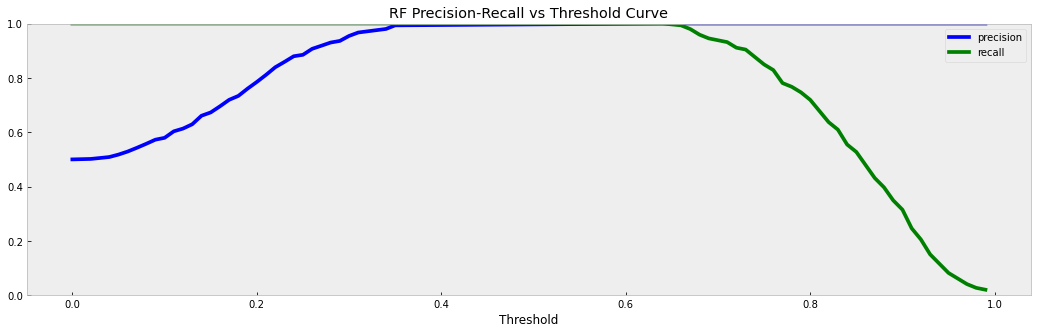

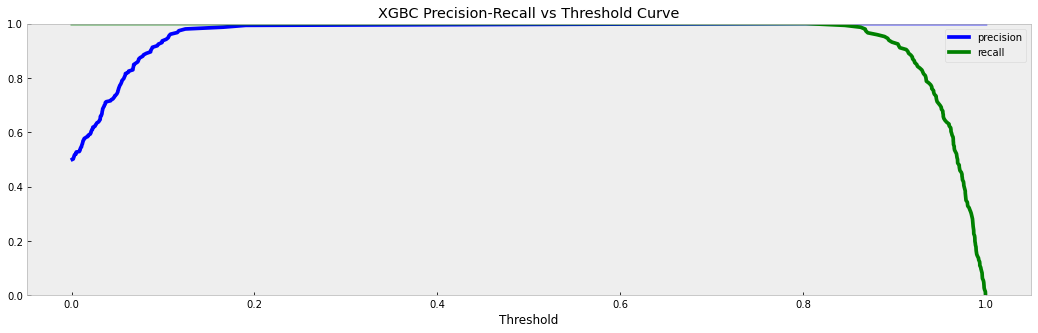

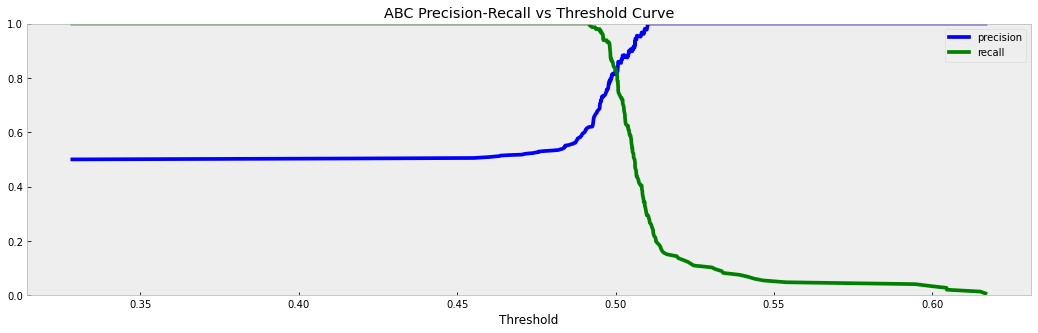

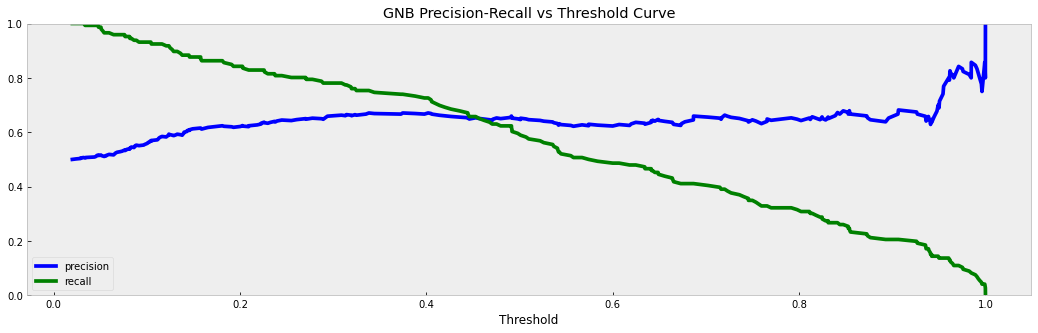

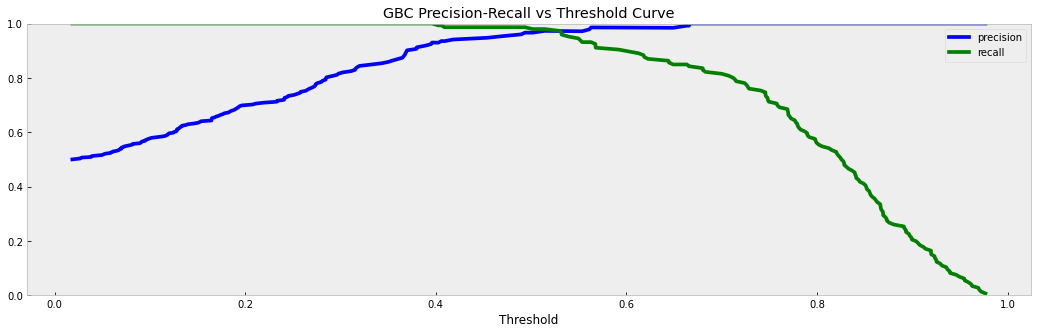

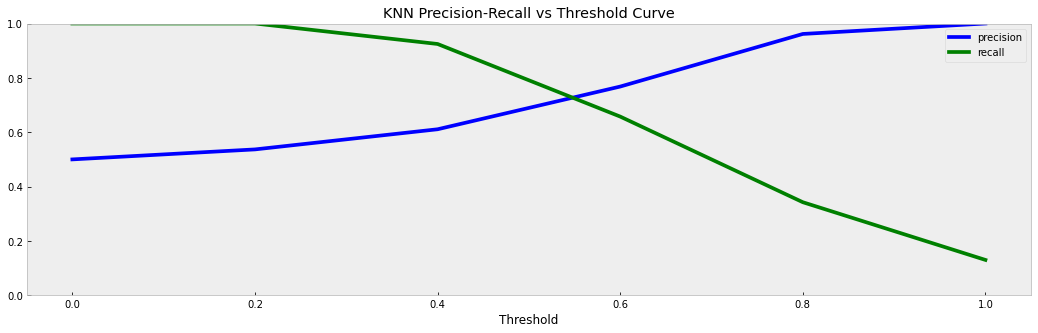

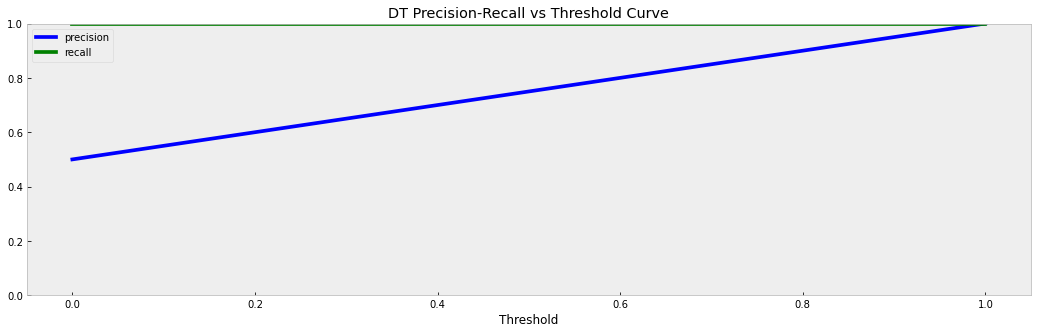

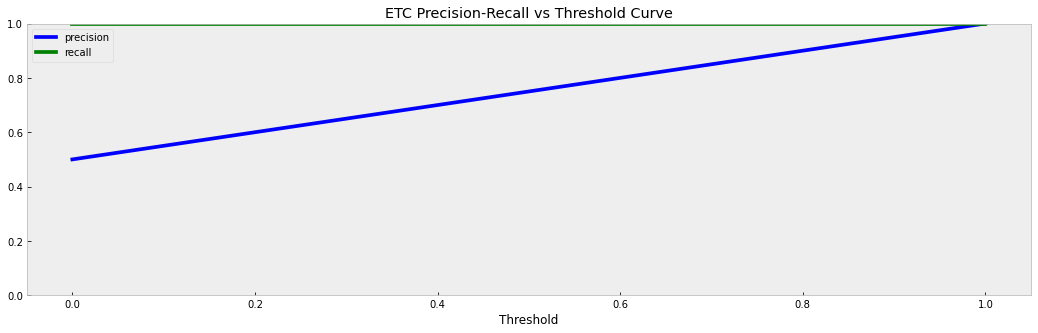

In [315]:
"""Function for plotting precision-recall vs threshold curve."""
def plotPrecisionRecallVsThresholdCurve(model, title):
    """Plots precision-recall vs threshold curve for a model."""

    probablity = model.predict_proba(xTrainu)[:, 1]
    plt.figure(figsize = (18, 5))
    precision, recall, threshold = precision_recall_curve(yTrainu, probablity)
    plt.plot(threshold, precision[:-1], "b-", label = "precision", lw = 3.7)
    plt.plot(threshold, recall[:-1], "g", label = "recall", lw = 3.7)
    plt.xlabel("Threshold")
    plt.legend(loc = "best")
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()

"""Now plot precision-recall vs threshold curve for the models."""

plotPrecisionRecallVsThresholdCurve(rf, title = "RF Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(xgbc, title = "XGBC Precision-Recall vs Threshold Curve")
plotPrecisionRecallVsThresholdCurve(abc, title = "ABC Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(gnb, title = "GNB Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(gbc, title = "GBC Precision-Recall vs Threshold Curve")
#plotPrecisionRecallVsThresholdCurve(svc, title = "SVC Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(knn, title = "KNN Precision-Recall vs Threshold Curve")
plotPrecisionRecallVsThresholdCurve(dt, title = "DT Precision-Recall vs Threshold Curve" )
plotPrecisionRecallVsThresholdCurve(etc, title = "ETC Precision-Recall vs Threshold Curve")

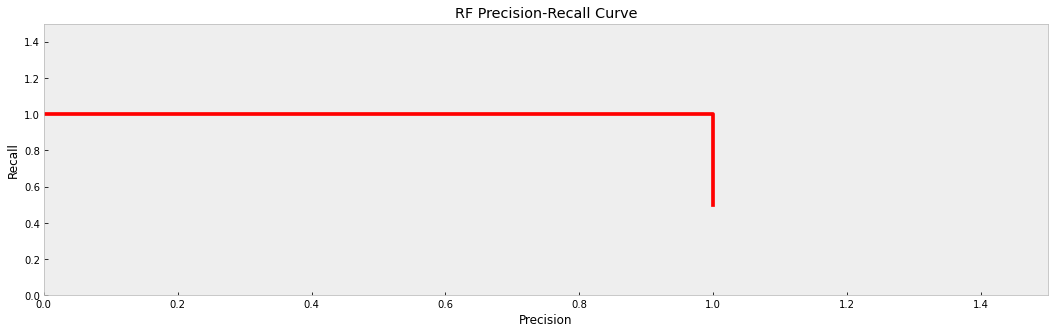

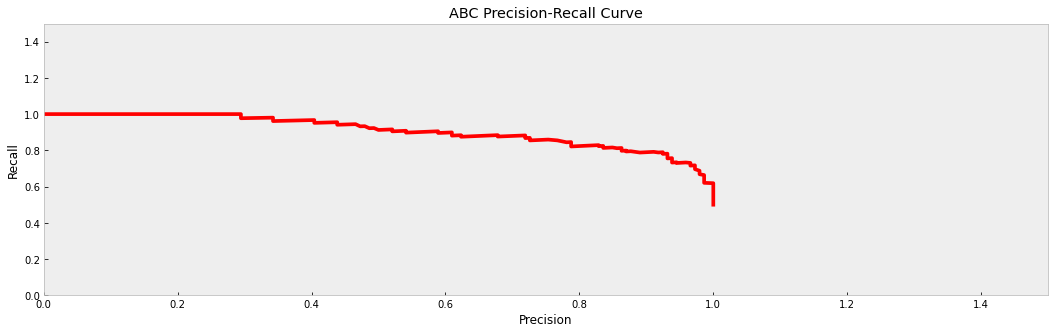

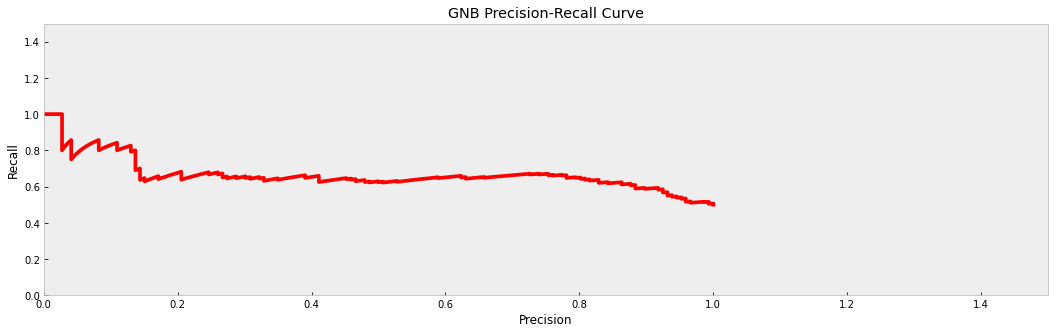

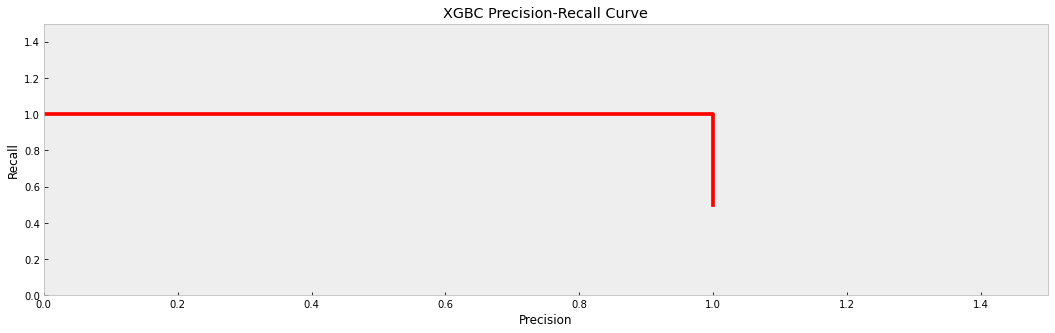

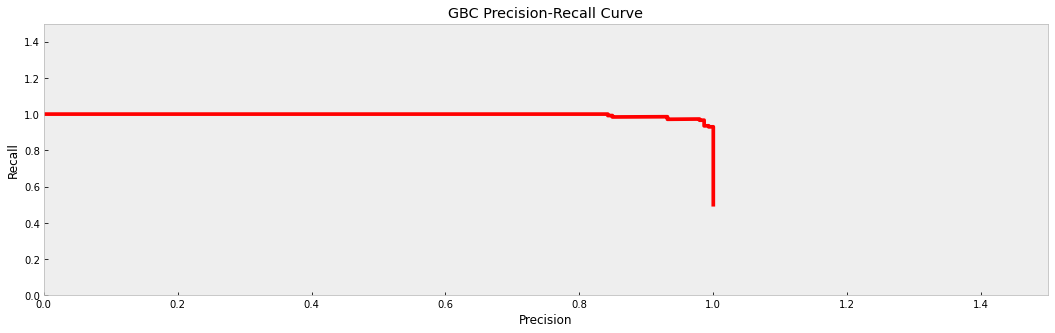

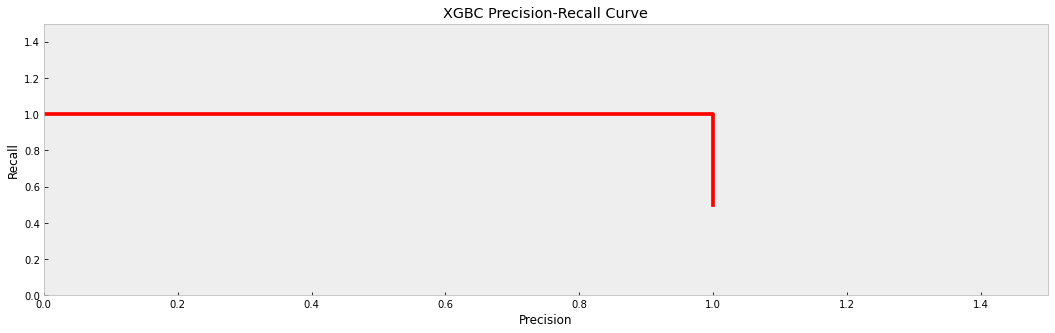

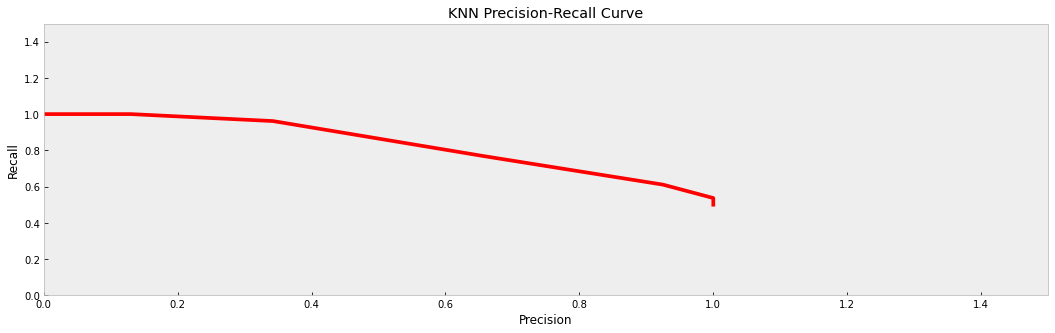

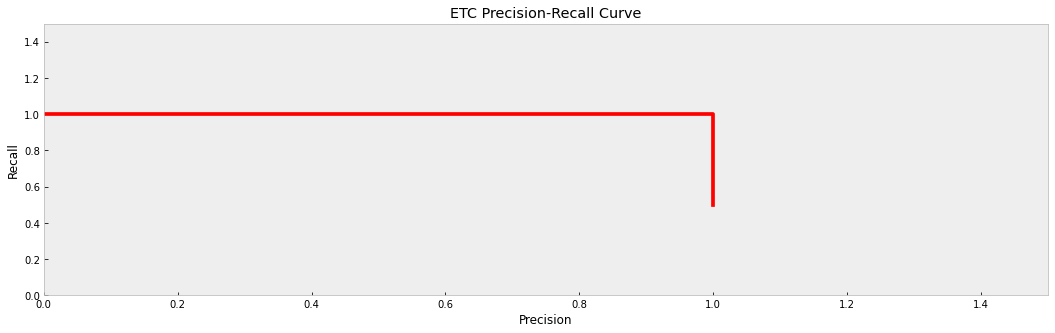

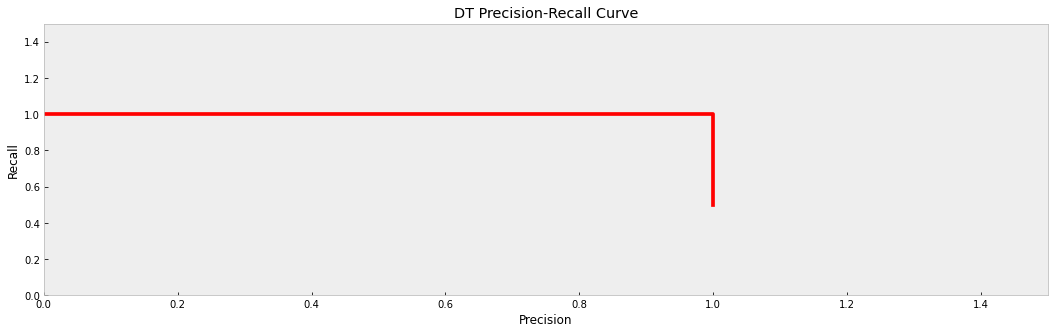

In [316]:
"""Function to plot recall vs precision curve."""
def plotPrecisionVsRecallCurve(model, title):
    """Return amodel's recall vs precision curve."""
    
    probablity = model.predict_proba(xTrainu)[:, 1]
    plt.figure(figsize = (18, 5))
    precision, recall, threshold = precision_recall_curve(yTrainu, probablity)
    plt.plot(recall, precision, "r-", lw = 3.7)
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.axis([0, 1.5, 0, 1.5])
    plt.title(title)
    plt.show()

"""Now plot recall vs precision curve of rf and gbc."""
plotPrecisionVsRecallCurve(rf, title = "RF Precision-Recall Curve")
plotPrecisionVsRecallCurve(abc, title = "ABC Precision-Recall Curve")
plotPrecisionVsRecallCurve(gnb, title = "GNB Precision-Recall Curve")
plotPrecisionVsRecallCurve(xgbc, title = "XGBC Precision-Recall Curve")
plotPrecisionVsRecallCurve(gbc, title = "GBC Precision-Recall Curve")
plotPrecisionVsRecallCurve(xgbc, title = "XGBC Precision-Recall Curve")
#plotPrecisionVsRecallCurve(svc, title = "svc Precision-Recall Curve")
plotPrecisionVsRecallCurve(knn, title = "KNN Precision-Recall Curve")
plotPrecisionVsRecallCurve(etc, title = "ETC Precision-Recall Curve")
plotPrecisionVsRecallCurve(dt, title = "DT Precision-Recall Curve")

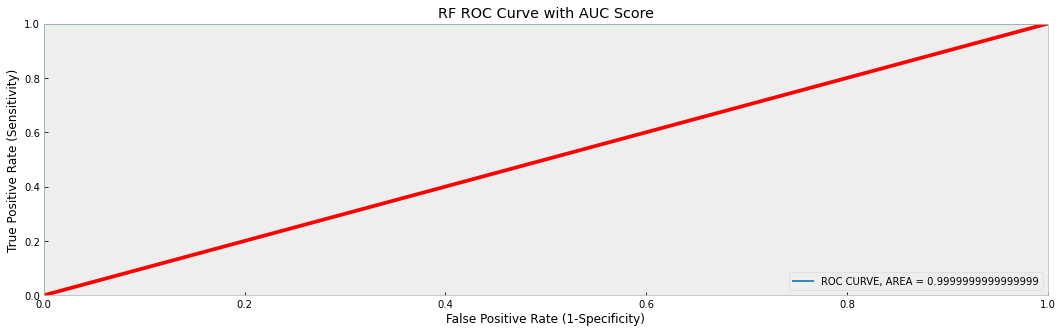

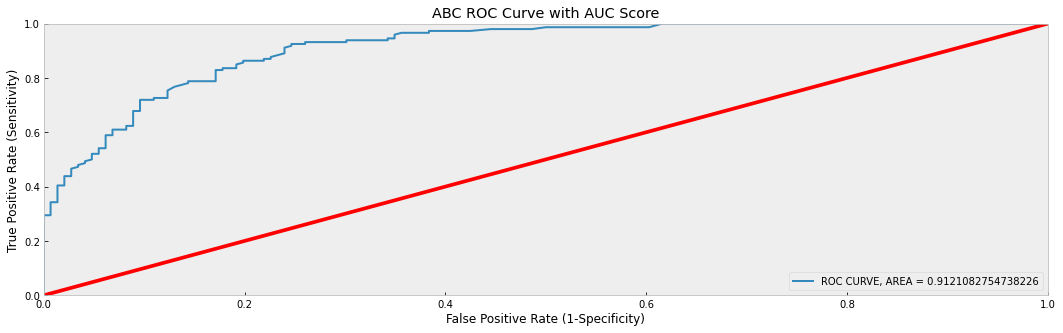

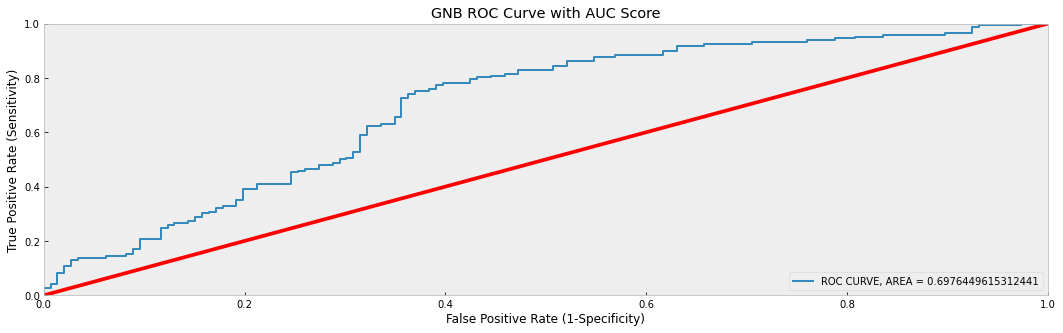

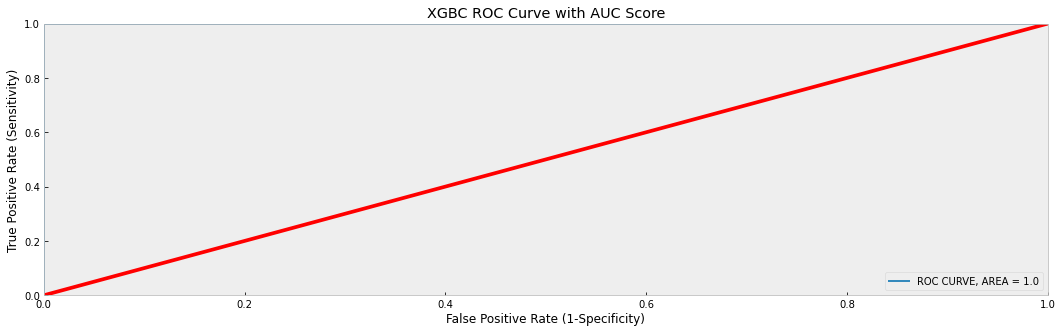

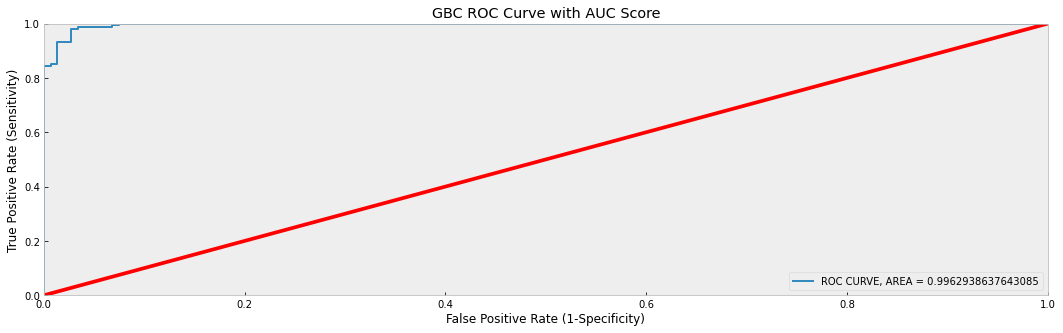

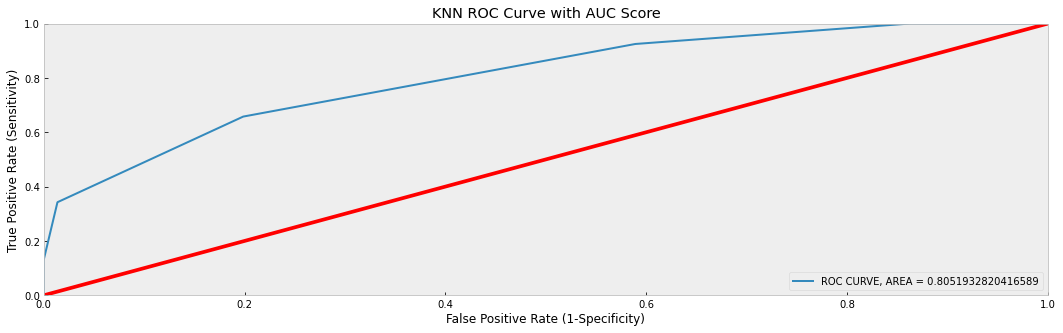

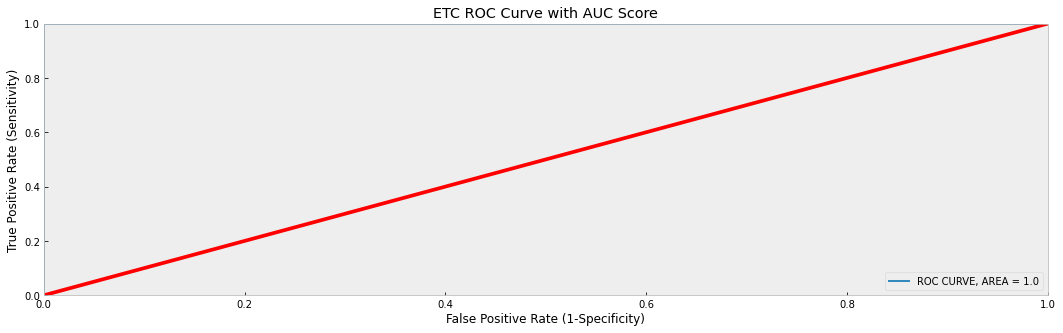

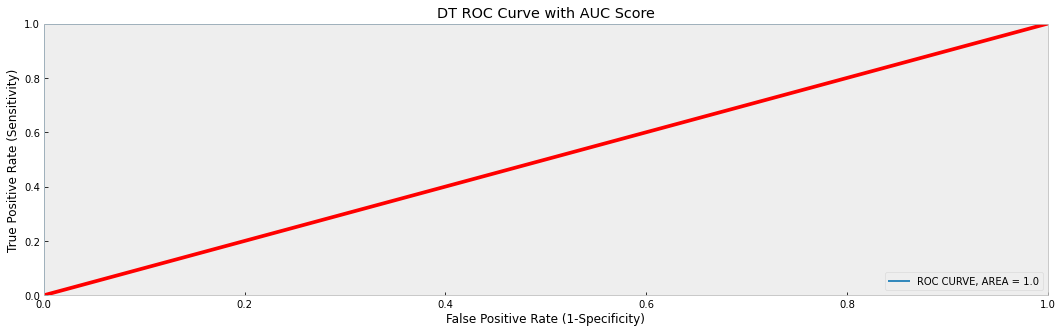

In [318]:
"""Function to plot ROC curve with AUC score."""
def plotRocAndAucScore(model, title):
    """Returns roc and auc score of a model."""
    
    probablity = model.predict_proba(xTrainu)[:, 1]
    plt.figure(figsize = (18, 5))
    false_positive_rate, true_positive_rate, threshold = roc_curve(yTrainu, probablity)
    auc_score = roc_auc_score(yTrainu, probablity)
    plt.plot(false_positive_rate, true_positive_rate, label = "ROC CURVE, AREA = "+ str(auc_score))
    plt.plot([0, 1], [0, 1], "red", lw = 3.7)
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.axis([0, 1, 0, 1])
    plt.legend(loc = 4)
    plt.title(title)
    plt.show()

"""Plot roc curve and auc score for the models."""
plotRocAndAucScore(rf, title = "RF ROC Curve with AUC Score")
plotRocAndAucScore(abc, title = "ABC ROC Curve with AUC Score")
plotRocAndAucScore(gnb, title = "GNB ROC Curve with AUC Score")
plotRocAndAucScore(xgbc, title = "XGBC ROC Curve with AUC Score")
plotRocAndAucScore(gbc, title = "GBC ROC Curve with AUC Score")
plotRocAndAucScore(knn, title = "KNN ROC Curve with AUC Score")
plotRocAndAucScore(etc, title = "ETC ROC Curve with AUC Score")
plotRocAndAucScore(dt, title = "DT ROC Curve with AUC Score")

**All the Base Models Prediction:**

RF  GBC  ABC  ETC  DT  SVC  KNN  LR
0   1    1    0    1   1    0    1   0
1   0    1    1    0   0    0    0   0
2   1    1    0    1   1    0    1   0
3   1    0    0    1   1    0    1   0
4   0    0    0    0   1    0    0   0

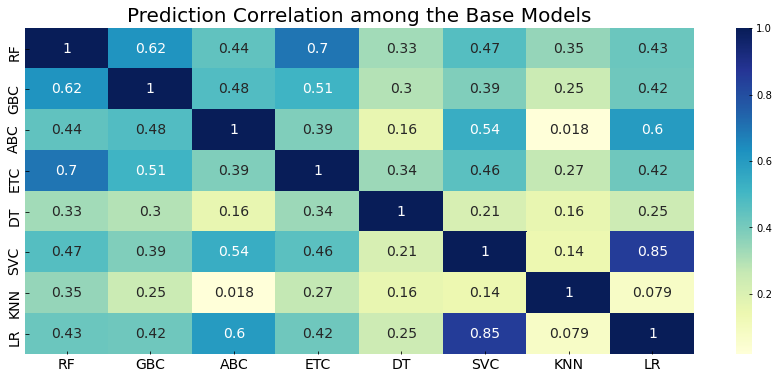

In [319]:
"""Make prediction using all the trained models."""
modelPrediction = pd.DataFrame({"RF":rf.predict(xTest),
                                 "GBC":gbc.predict(xTest),
                                 "ABC":abc.predict(xTest),
                                 "ETC":etc.predict(xTest), 
                                 "DT":dt.predict(xTest),
                                 "SVC":svc.predict(xTest), 
                                 "KNN":knn.predict(xTest), 
                                 "LR":lr.predict(xTest)
                                })


"""Create a data frame to store base models prediction.
First 5 in the dataframe are tree based models. Then two are kernel based. 
And the last is a linear model."""
basePrediction = modelPrediction # We"ve a df of all the models prediction.

"""Let"s see how each model classifies a prticular class."""
bold("All the Base Models Prediction:")
display(basePrediction.head())

"""Let"s visualize the correlations among the predictions of base models."""
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.heatmap(basePrediction.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Prediction Correlation among the Base Models", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
ax.tick_params(axis = "both", which = "minor", labelsize = 14)

Conclusion: It turns out Most models train better under oversampling with SMOTE, then undersampling with NearMiss. However, these models are more accurate in predicting unseen data without resampling as seen next.

## 6. Model Testing Evaluation

Let's summarize the model accuracy scores in this case.

Training Accuracy    : 78.82 %
Model Accuracy Score : 80.59 %
--------------------------------------------------------


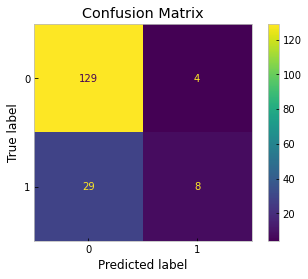

In [374]:
# Logistic Regression with no resampling
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression()  
lr.fit(xTrain, yTrain)
y_pred_lr = lr.predict(xTest)

lr_train = round(lr.score(xTrain, yTrain) * 100, 2)
lr_accuracy = round(accuracy_score(y_pred_lr, yTest) * 100, 2)

print("Training Accuracy    :",lr_train ,"%")
print("Model Accuracy Score :",lr_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(lr, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 78.53 %
Model Accuracy Score : 78.24 %
--------------------------------------------------------


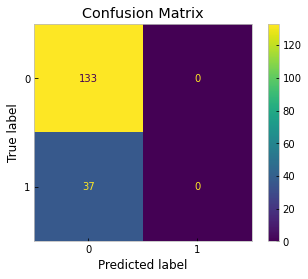

In [359]:
# Support vctor Machine with no resampling
svc.fit(xTrain, yTrain)
y_pred_svc = svc.predict(xTest)

svc_train = round(svc.score(xTrain, yTrain) * 100, 2)
svc_accuracy = round(accuracy_score(y_pred_svc, yTest) * 100, 2)

print("Training Accuracy    :",svc_train ,"%")
print("Model Accuracy Score :",svc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(svc, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 72.35 %
Model Accuracy Score : 79.41 %
--------------------------------------------------------


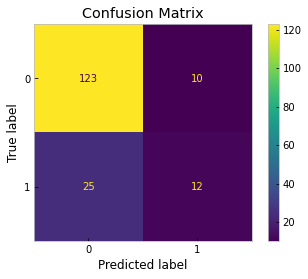

In [358]:
# Randomforest with no resampling
rf.fit(xTrain, yTrain)
y_pred_rf = rf.predict(xTest)

rf_train = round(svc.score(xTrain, yTrain) * 100, 2)
rf_accuracy = round(accuracy_score(y_pred_rf, yTest) * 100, 2)

print("Training Accuracy    :",rf_train ,"%")
print("Model Accuracy Score :",rf_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(rf, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 83.68 %
Model Accuracy Score : 77.65 %
--------------------------------------------------------


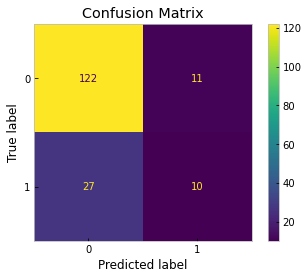

In [354]:
# KneighborsClassifier with no resampling
knn.fit(xTrain, yTrain)
y_pred_knn = knn.predict(xTest)

knn_train = round(knn.score(xTrain, yTrain) * 100, 2)
knn_accuracy = round(accuracy_score(y_pred_knn, yTest) * 100, 2)

print("Training Accuracy    :",knn_train ,"%")
print("Model Accuracy Score :",knn_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(knn, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 78.38 %
Model Accuracy Score : 77.65 %
--------------------------------------------------------


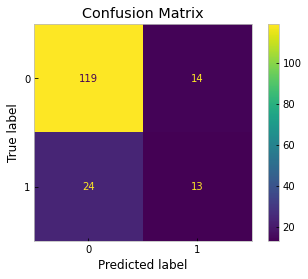

In [353]:
# Gaussian Naive Bayes with no resampling
gnb.fit(xTrain, yTrain)
y_pred_gnb = gnb.predict(xTest)

gnb_train = round(gnb.score(xTrain, yTrain) * 100, 2)
gnb_accuracy = round(accuracy_score(y_pred_gnb, yTest) * 100, 2)

print("Training Accuracy    :",gnb_train ,"%")
print("Model Accuracy Score :",gnb_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(gnb, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 100.0 %
Model Accuracy Score : 73.53 %
--------------------------------------------------------


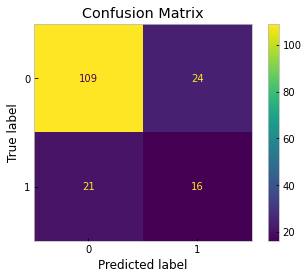

In [352]:
# Decision Tree Classifier with no resampling
dt.fit(xTrain, yTrain)
y_pred_dt = dt.predict(xTest)

dt_train = round(dt.score(xTrain, yTrain) * 100, 2)
dt_accuracy = round(accuracy_score(y_pred_dt, yTest) * 100, 2)

print("Training Accuracy    :",dt_train ,"%")
print("Model Accuracy Score :",dt_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(dt, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 93.24 %
Model Accuracy Score : 81.76 %
--------------------------------------------------------


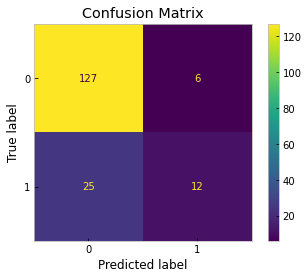

In [351]:
# GradientBoostingClassifier with no resampling
gbc.fit(xTrain, yTrain)
y_pred_gbc = gbc.predict(xTest)

gbc_train = round(gbc.score(xTrain, yTrain) * 100, 2)
gbc_accuracy = round(accuracy_score(y_pred_gbc, yTest) * 100, 2)

print("Training Accuracy    :",gbc_train ,"%")
print("Model Accuracy Score :",gbc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(gbc, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 84.71 %
Model Accuracy Score : 78.82 %
--------------------------------------------------------


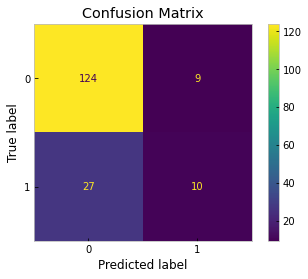

In [368]:
#  AdaBoostClassifier with no resampling
abc.fit(xTrain, yTrain)
y_pred_abc = abc.predict(xTest)

abc_train = round(abc.score(xTrain, yTrain) * 100, 2)
abc_accuracy = round(accuracy_score(y_pred_abc, yTest) * 100, 2)

print("Training Accuracy    :",abc_train ,"%")
print("Model Accuracy Score :",abc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(abc, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 100.0 %
Model Accuracy Score : 80.59 %
--------------------------------------------------------


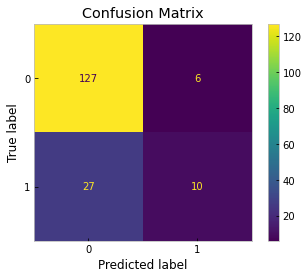

In [370]:
# ExtraTreesClassifier with no resampling
etc.fit(xTrain, yTrain)
y_pred_etc = etc.predict(xTest)

etc_train = round(etc.score(xTrain, yTrain) * 100, 2)
etc_accuracy = round(accuracy_score(y_pred_etc, yTest) * 100, 2)

print("Training Accuracy    :",etc_train ,"%")
print("Model Accuracy Score :",etc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(etc, xTest, yTest);
plt.title('Confusion Matrix');

Training Accuracy    : 100.0 %
Model Accuracy Score : 81.76 %
--------------------------------------------------------


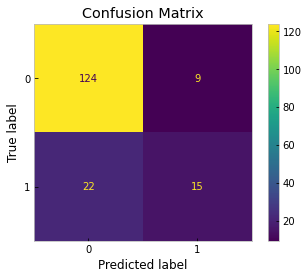

In [371]:
# Extreme Gradient Boosting with no resampling
xgbc.fit(xTrain, yTrain)
y_pred_xgbc = xgbc.predict(xTest)

xgbc_train = round(xgbc.score(xTrain, yTrain) * 100, 2)
xgbc_accuracy = round(accuracy_score(y_pred_xgbc, yTest) * 100, 2)

print("Training Accuracy    :",xgbc_train ,"%")
print("Model Accuracy Score :",xgbc_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
plot_confusion_matrix(xgbc, xTest, yTest);
plt.title('Confusion Matrix');

#### Model Accuracy scores Comparison

In [375]:
Models = pd.DataFrame({
    'Model': [
        'Logistic Regression','Decision Tree Classifier','KNN', 'Ada Boost Classifier', 'Gradient Boosting Classifier',
        'ExtraTrees Classifier','RandomForestClassifier','Gaussian Naive Bayes','Extreme Gradient Boosting', 'Support Vector Machines'
        
    ],
    
    'Model Accuracy Score (%)': [
        lr_accuracy, dt_accuracy, knn_accuracy,abc_accuracy,gbc_accuracy, 
       etc_accuracy, rf_accuracy, gnb_accuracy, xgbc_accuracy, svc_accuracy,
    ]
})

In [376]:
pd.set_option("display.precision",2)

Models.sort_values(by='Model Accuracy Score (%)', ascending=False).style.background_gradient(
        cmap='coolwarm').hide_index().set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

## 7. Using the Best Model for Predictions

The Gradient Boosting Classifier appears to be the best model. We will use it to make prediction

In [397]:
#Input data as a numpy array
Input_data = X.sample(1)
#changing to numpy array
Input_data = np.asarray(Input_data)
#reshape the array as we are predicting for one instance
Input_data=Input_data.reshape(1,-1)
#Standardize the input data
#std_data = scaler.transform(Input_data)
print(Input_data)
prediction =gbc.predict(Input_data)
print(prediction)

if (prediction[0] == 0):
    print('CONCLUSION: The client will not default')
else:
    print('CONCLUSION: The client will default')

[[ 20  19   0  15  66 214 407]]
[0]
CONCLUSION: The client will not default


Some codes in this notebook were borrowed from https://www.kaggle.com/eraaz1